# Deep Convolutional GAN (DCGAN) for MNIST Generation

## Overview

Deep Convolutional GANs (DCGAN) represent a major breakthrough in GAN training stability. By using convolutional architectures and specific design guidelines, DCGAN achieves much more stable training than vanilla GANs.

## Key Concepts

### 1. DCGAN Architecture Guidelines
The DCGAN paper established crucial architectural guidelines:

**For Stable Training:**
- Replace pooling layers with **strided convolutions** (discriminator) and **fractional-strided convolutions** (generator)
- Use **batch normalization** in both generator and discriminator
- Remove **fully connected hidden layers** for deeper architectures
- Use **ReLU activation** in generator for all layers except output (which uses **Tanh**)
- Use **LeakyReLU activation** in discriminator for all layers

### 2. Convolutional Architecture Benefits
**Why Convolutions Work Better:**
- **Spatial structure preservation**: Maintains 2D image structure throughout network
- **Parameter efficiency**: Fewer parameters than fully connected layers
- **Translation invariance**: Better feature learning for images
- **Hierarchical features**: Learn from low-level edges to high-level concepts

### 3. Proven Hyperparameters
**Research-Validated Settings:**
- **Learning rate**: 0.0002 for both networks
- **Adam beta1**: 0.5 (instead of default 0.9)
- **Batch size**: 128
- **Weight initialization**: Normal(0, 0.02)
- **LeakyReLU slope**: 0.2

### 4. Mathematical Foundation

**Generator Transformation:**
$$z \in \mathbb{R}^{100} \rightarrow x \in \mathbb{R}^{28 \times 28}$$

**Discriminator Classification:**
$$x \in \mathbb{R}^{28 \times 28} \rightarrow P(x \text{ is real}) \in [0,1]$$

**Adversarial Loss (same as vanilla GAN):**
$$\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]$$

### 5. DCGAN vs Vanilla GAN Advantages

| Aspect | Vanilla GAN | DCGAN |
|--------|-------------|-------|
| **Architecture** | Fully connected | Convolutional |
| **Training Stability** | Very unstable | Much more stable |
| **Image Quality** | Poor | Excellent |
| **Feature Learning** | Limited | Hierarchical |
| **Mode Collapse** | Common | Less frequent |
| **Hyperparameter Sensitivity** | Extreme | Moderate |

### 6. Training Stability Improvements
**Why DCGAN is More Stable:**
- **Batch normalization** reduces internal covariate shift
- **Strided convolutions** provide smooth gradients
- **Architectural constraints** prevent pathological behaviors
- **Proven hyperparameters** from extensive research

## Implementation: Imports and Data Preprocessing

DCGAN works with standard image preprocessing - no dequantization needed:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# DCGAN hyperparameters (research-proven for MNIST)
BATCH_SIZE = 128
IMAGE_SIZE = 64  # DCGAN works best with powers of 2
NC = 1  # Number of channels (grayscale)
NZ = 100  # Size of latent vector
NGF = 64  # Generator feature map size
NDF = 64  # Discriminator feature map size
LR = 0.0002  # Learning rate
BETA1 = 0.5  # Beta1 hyperparam for Adam optimizers
NUM_EPOCHS = 25

# Device setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# MNIST dataset with transforms for DCGAN
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),  # Resize to 64x64 for DCGAN
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] for tanh output
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print(f"Dataset loaded: {len(dataset)} images")
print(f"Batch size: {BATCH_SIZE}")
print(f"Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"Data range: [-1, 1] (normalized for tanh output)")

Using device: cuda:0


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.61MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.34MB/s]

Dataset loaded: 60000 images
Batch size: 128
Image size: 64x64
Data range: [-1, 1] (normalized for tanh output)


## Weight Initialization: Critical for DCGAN Success

Proper weight initialization is crucial for DCGAN training stability. The original paper specifies exact initialization schemes:

In [2]:
def weights_init(m):
    """
    DCGAN weight initialization from the paper:
    "All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02"

    This initialization is critical for stable DCGAN training.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Initialize convolution layer weights
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        # Initialize batch normalization weights and biases
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

print("Weight initialization function defined.")
print("DCGAN paper specification: Normal(mean=0, std=0.02) for all weights")

Weight initialization function defined.
DCGAN paper specification: Normal(mean=0, std=0.02) for all weights


## DCGAN Generator: Fractional-Strided Convolutions

The Generator uses **fractional-strided convolutions** (transposed convolutions) to upscale from noise to images:

**Architecture Flow:**
```
Noise(100) → ConvTranspose2d → BatchNorm → ReLU → ... → ConvTranspose2d → Tanh → Image(64x64)
```

**Key Design Principles:**
- No fully connected layers
- Batch normalization after each layer (except output)
- ReLU activation (except Tanh for output)
- Systematic upsampling: 1×1 → 4×4 → 8×8 → 16×16 → 32×32 → 64×64

In [3]:
class DCGANGenerator(nn.Module):
    """
    DCGAN Generator Network

    Transforms noise vector z ∈ R^100 into image x ∈ R^64×64
    Uses fractional-strided convolutions (ConvTranspose2d) for upsampling

    Architecture follows DCGAN paper guidelines:
    - No fully connected layers
    - Batch normalization everywhere except output
    - ReLU activations except Tanh for output
    """
    def __init__(self, nz=100, ngf=64, nc=1):
        super(DCGANGenerator, self).__init__()

        self.main = nn.Sequential(
            # Input: noise vector z, output: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # State size: (ngf*8) x 4 x 4 → (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # State size: (ngf*4) x 8 x 8 → (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # State size: (ngf*2) x 16 x 16 → ngf x 32 x 32
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # State size: ngf x 32 x 32 → nc x 64 x 64
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, input):
        """
        Forward pass: noise → image

        Args:
            input: Noise tensor [batch_size, nz, 1, 1]

        Returns:
            Generated images [batch_size, nc, 64, 64]
        """
        return self.main(input)

# Initialize generator
netG = DCGANGenerator(nz=NZ, ngf=NGF, nc=NC).to(device)
netG.apply(weights_init)  # Apply DCGAN weight initialization

print(f"DCGAN Generator initialized:")
print(f"  Input: Noise vector [{NZ}]")
print(f"  Output: Image [1, 64, 64]")
print(f"  Parameters: {sum(p.numel() for p in netG.parameters()):,}")
print(f"  Architecture: 5 ConvTranspose2d layers with BatchNorm + ReLU")

# Test generator
test_noise = torch.randn(1, NZ, 1, 1, device=device)
with torch.no_grad():
    test_output = netG(test_noise)
    print(f"\nTest generation:")
    print(f"  Input shape: {test_noise.shape}")
    print(f"  Output shape: {test_output.shape}")
    print(f"  Output range: [{test_output.min():.3f}, {test_output.max():.3f}]")

DCGAN Generator initialized:
  Input: Noise vector [100]
  Output: Image [1, 64, 64]
  Parameters: 3,574,656
  Architecture: 5 ConvTranspose2d layers with BatchNorm + ReLU

Test generation:
  Input shape: torch.Size([1, 100, 1, 1])
  Output shape: torch.Size([1, 1, 64, 64])
  Output range: [-0.840, 0.611]


## DCGAN Discriminator: Strided Convolutions

The Discriminator uses **strided convolutions** for downsampling, replacing pooling layers:

**Architecture Flow:**
```
Image(64x64) → Conv2d → LeakyReLU → ... → Conv2d → Sigmoid → Probability
```

**Key Design Principles:**
- No pooling layers (use strided convolutions)
- Batch normalization (except first and last layer)
- LeakyReLU activation (slope = 0.2)
- Systematic downsampling: 64×64 → 32×32 → 16×16 → 8×8 → 4×4 → 1×1

In [4]:
class DCGANDiscriminator(nn.Module):
    """
    DCGAN Discriminator Network

    Classifies images as real or fake: x ∈ R^64×64 → P(real) ∈ [0,1]
    Uses strided convolutions for downsampling (no pooling)

    Architecture follows DCGAN paper guidelines:
    - No fully connected layers
    - Batch normalization (except first and last layer)
    - LeakyReLU activations with slope 0.2
    """
    def __init__(self, nc=1, ndf=64):
        super(DCGANDiscriminator, self).__init__()

        self.main = nn.Sequential(
            # Input: nc x 64 x 64 → ndf x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),  # No BatchNorm for first layer

            # State size: ndf x 32 x 32 → (ndf*2) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: (ndf*2) x 16 x 16 → (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: (ndf*4) x 8 x 8 → (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: (ndf*8) x 4 x 4 → 1 x 1 x 1
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Output probability [0, 1]
        )

    def forward(self, input):
        """
        Forward pass: image → probability

        Args:
            input: Input images [batch_size, nc, 64, 64]

        Returns:
            Probability that input is real [batch_size, 1, 1, 1]
        """
        return self.main(input)

# Initialize discriminator
netD = DCGANDiscriminator(nc=NC, ndf=NDF).to(device)
netD.apply(weights_init)  # Apply DCGAN weight initialization

print(f"DCGAN Discriminator initialized:")
print(f"  Input: Image [1, 64, 64]")
print(f"  Output: Probability [1, 1, 1]")
print(f"  Parameters: {sum(p.numel() for p in netD.parameters()):,}")
print(f"  Architecture: 5 Conv2d layers with BatchNorm + LeakyReLU")

# Test discriminator
test_image = torch.randn(1, NC, IMAGE_SIZE, IMAGE_SIZE, device=device)
with torch.no_grad():
    test_pred = netD(test_image)
    print(f"\nTest discrimination:")
    print(f"  Input shape: {test_image.shape}")
    print(f"  Output shape: {test_pred.shape}")
    print(f"  Output value: {test_pred.item():.3f} (probability)")

DCGAN Discriminator initialized:
  Input: Image [1, 64, 64]
  Output: Probability [1, 1, 1]
  Parameters: 2,763,520
  Architecture: 5 Conv2d layers with BatchNorm + LeakyReLU

Test discrimination:
  Input shape: torch.Size([1, 1, 64, 64])
  Output shape: torch.Size([1, 1, 1, 1])
  Output value: 0.230 (probability)


## DCGAN Training: Stable Adversarial Learning

DCGAN training uses the same adversarial loss as vanilla GAN but with much more stable architecture and hyperparameters:

### Research-Proven Training Recipe

**Optimizers:**
- **Adam optimizer** with lr=0.0002, beta1=0.5 (critical!)
- **Same learning rate** for both networks
- **No learning rate scheduling** needed

**Training Strategy:**
- **Alternate training**: One batch D, then one batch G
- **Standard adversarial loss** (no modifications needed)
- **25+ epochs** for good results

**Monitoring:**
- Generator and discriminator losses
- Visual samples every few epochs
- D(real) and D(fake) statistics

In [5]:
# Loss function
criterion = nn.BCELoss()

# Create batch of latent vectors for visualization
fixed_noise = torch.randn(64, NZ, 1, 1, device=device)

# Establish convention for real and fake labels
real_label = 1.
fake_label = 0.

# Setup Adam optimizers with DCGAN hyperparameters
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(BETA1, 0.999))

print("=== DCGAN Training Setup ===")
print(f"Loss function: Binary Cross Entropy")
print(f"Optimizer: Adam(lr={LR}, beta1={BETA1})")
print(f"Real label: {real_label}, Fake label: {fake_label}")
print(f"Fixed noise for visualization: {fixed_noise.shape}")
print(f"Training epochs: {NUM_EPOCHS}")

def generate_and_save_images(generator, epoch, test_noise, device):
    """
    Generate and display images from the generator
    """
    generator.eval()
    with torch.no_grad():
        fake_images = generator(test_noise).detach().cpu()
        # Denormalize from [-1, 1] to [0, 1]
        fake_images = (fake_images + 1) / 2.0

        # Create grid of images
        fig, axes = plt.subplots(8, 8, figsize=(8, 8))
        for i in range(8):
            for j in range(8):
                idx = i * 8 + j
                axes[i, j].imshow(fake_images[idx].squeeze(), cmap='gray')
                axes[i, j].axis('off')

        plt.suptitle(f'DCGAN Generated MNIST - Epoch {epoch}')
        plt.tight_layout()
        plt.show()

    generator.train()

print("\nGeneration function defined. Ready to start training!")

=== DCGAN Training Setup ===
Loss function: Binary Cross Entropy
Optimizer: Adam(lr=0.0002, beta1=0.5)
Real label: 1.0, Fake label: 0.0
Fixed noise for visualization: torch.Size([64, 100, 1, 1])
Training epochs: 25

Generation function defined. Ready to start training!


## Training Loop: Adversarial Learning in Action

The DCGAN training loop follows the standard adversarial training pattern but benefits from architectural stability:

Starting DCGAN Training...


Epoch 1/25:   0%|          | 2/469 [00:00<03:12,  2.43it/s]

[1/25][0/469] Loss_D: 1.7809 Loss_G: 2.6652 D(x): 0.3540 D(G(z)): 0.3647 / 0.0984


Epoch 1/25:  11%|█         | 52/469 [00:08<01:04,  6.49it/s]

[1/25][50/469] Loss_D: 0.0326 Loss_G: 16.1900 D(x): 0.9732 D(G(z)): 0.0000 / 0.0000


Epoch 1/25:  22%|██▏       | 102/469 [00:15<00:55,  6.61it/s]

[1/25][100/469] Loss_D: 2.2846 Loss_G: 17.3532 D(x): 0.9955 D(G(z)): 0.7459 / 0.0000


Epoch 1/25:  32%|███▏      | 152/469 [00:23<00:48,  6.49it/s]

[1/25][150/469] Loss_D: 0.1084 Loss_G: 5.5600 D(x): 0.9656 D(G(z)): 0.0641 / 0.0055


Epoch 1/25:  43%|████▎     | 202/469 [00:31<00:42,  6.23it/s]

[1/25][200/469] Loss_D: 0.1540 Loss_G: 3.9491 D(x): 0.9382 D(G(z)): 0.0806 / 0.0255


Epoch 1/25:  54%|█████▎    | 252/469 [00:39<00:35,  6.17it/s]

[1/25][250/469] Loss_D: 0.5528 Loss_G: 5.1910 D(x): 0.9835 D(G(z)): 0.3366 / 0.0099


Epoch 1/25:  64%|██████▍   | 302/469 [00:47<00:27,  6.00it/s]

[1/25][300/469] Loss_D: 0.1775 Loss_G: 3.4084 D(x): 0.8872 D(G(z)): 0.0444 / 0.0508


Epoch 1/25:  75%|███████▌  | 352/469 [00:56<00:19,  6.02it/s]

[1/25][350/469] Loss_D: 0.3590 Loss_G: 4.2465 D(x): 0.9450 D(G(z)): 0.2297 / 0.0242


Epoch 1/25:  86%|████████▌ | 402/469 [01:04<00:10,  6.17it/s]

[1/25][400/469] Loss_D: 0.8487 Loss_G: 9.3766 D(x): 0.9966 D(G(z)): 0.5073 / 0.0002


Epoch 1/25:  96%|█████████▋| 452/469 [01:12<00:02,  6.25it/s]

[1/25][450/469] Loss_D: 0.3770 Loss_G: 5.5814 D(x): 0.9591 D(G(z)): 0.2529 / 0.0073


Epoch 1/25: 100%|██████████| 469/469 [01:15<00:00,  6.22it/s]



Epoch 1 Summary:
  Average D Loss: 0.5177
  Average G Loss: 6.2191
  Final D(x): 0.9368
  Final D(G(z)): 0.0584


Epoch 2/25:   0%|          | 2/469 [00:00<01:35,  4.90it/s]

[2/25][0/469] Loss_D: 0.2290 Loss_G: 3.2175 D(x): 0.9128 D(G(z)): 0.1180 / 0.0549


Epoch 2/25:  11%|█         | 52/469 [00:08<01:05,  6.40it/s]

[2/25][50/469] Loss_D: 0.4801 Loss_G: 2.0483 D(x): 0.7179 D(G(z)): 0.1015 / 0.1644


Epoch 2/25:  22%|██▏       | 102/469 [00:16<00:57,  6.40it/s]

[2/25][100/469] Loss_D: 0.7628 Loss_G: 1.9615 D(x): 0.5974 D(G(z)): 0.0796 / 0.2053


Epoch 2/25:  32%|███▏      | 152/469 [00:24<00:49,  6.38it/s]

[2/25][150/469] Loss_D: 0.2987 Loss_G: 2.5830 D(x): 0.8523 D(G(z)): 0.1133 / 0.1046


Epoch 2/25:  43%|████▎     | 202/469 [00:31<00:42,  6.25it/s]

[2/25][200/469] Loss_D: 0.1932 Loss_G: 3.0760 D(x): 0.9032 D(G(z)): 0.0798 / 0.0618


Epoch 2/25:  54%|█████▎    | 252/469 [00:39<00:34,  6.29it/s]

[2/25][250/469] Loss_D: 0.5520 Loss_G: 3.1175 D(x): 0.8855 D(G(z)): 0.3153 / 0.0586


Epoch 2/25:  64%|██████▍   | 302/469 [00:47<00:26,  6.24it/s]

[2/25][300/469] Loss_D: 0.3781 Loss_G: 1.4265 D(x): 0.7568 D(G(z)): 0.0714 / 0.2864


Epoch 2/25:  75%|███████▌  | 352/469 [00:55<00:18,  6.19it/s]

[2/25][350/469] Loss_D: 0.3980 Loss_G: 1.9930 D(x): 0.8047 D(G(z)): 0.1398 / 0.1752


Epoch 2/25:  86%|████████▌ | 402/469 [01:04<00:10,  6.21it/s]

[2/25][400/469] Loss_D: 0.4364 Loss_G: 2.2970 D(x): 0.8061 D(G(z)): 0.1723 / 0.1336


Epoch 2/25:  96%|█████████▋| 452/469 [01:12<00:02,  6.23it/s]

[2/25][450/469] Loss_D: 0.4188 Loss_G: 2.5496 D(x): 0.8374 D(G(z)): 0.1890 / 0.0974


Epoch 2/25: 100%|██████████| 469/469 [01:14<00:00,  6.27it/s]



Epoch 2 Summary:
  Average D Loss: 0.6480
  Average G Loss: 2.4892
  Final D(x): 0.8978
  Final D(G(z)): 0.0795


Epoch 3/25:   0%|          | 2/469 [00:00<01:36,  4.86it/s]

[3/25][0/469] Loss_D: 0.3420 Loss_G: 2.4224 D(x): 0.8338 D(G(z)): 0.1257 / 0.1166


Epoch 3/25:  11%|█         | 52/469 [00:08<01:06,  6.28it/s]

[3/25][50/469] Loss_D: 0.4441 Loss_G: 2.8589 D(x): 0.8719 D(G(z)): 0.2406 / 0.0803


Epoch 3/25:  22%|██▏       | 102/469 [00:16<00:58,  6.32it/s]

[3/25][100/469] Loss_D: 1.4640 Loss_G: 1.2799 D(x): 0.3554 D(G(z)): 0.0448 / 0.3691


Epoch 3/25:  32%|███▏      | 152/469 [00:24<00:50,  6.31it/s]

[3/25][150/469] Loss_D: 0.3750 Loss_G: 4.2560 D(x): 0.9648 D(G(z)): 0.2632 / 0.0188


Epoch 3/25:  43%|████▎     | 202/469 [00:32<00:42,  6.23it/s]

[3/25][200/469] Loss_D: 0.8978 Loss_G: 1.0963 D(x): 0.5374 D(G(z)): 0.1647 / 0.3977


Epoch 3/25:  54%|█████▎    | 252/469 [00:40<00:34,  6.28it/s]

[3/25][250/469] Loss_D: 0.4507 Loss_G: 3.3867 D(x): 0.9273 D(G(z)): 0.2883 / 0.0444


Epoch 3/25:  64%|██████▍   | 302/469 [00:48<00:26,  6.26it/s]

[3/25][300/469] Loss_D: 0.2641 Loss_G: 2.3390 D(x): 0.8586 D(G(z)): 0.0922 / 0.1200


Epoch 3/25:  75%|███████▌  | 352/469 [00:56<00:19,  6.11it/s]

[3/25][350/469] Loss_D: 0.4214 Loss_G: 2.0708 D(x): 0.7169 D(G(z)): 0.0509 / 0.1637


Epoch 3/25:  86%|████████▌ | 402/469 [01:04<00:10,  6.31it/s]

[3/25][400/469] Loss_D: 0.2738 Loss_G: 3.5238 D(x): 0.9168 D(G(z)): 0.1581 / 0.0395


Epoch 3/25:  96%|█████████▋| 452/469 [01:12<00:02,  6.28it/s]

[3/25][450/469] Loss_D: 0.5970 Loss_G: 3.5852 D(x): 0.9236 D(G(z)): 0.3684 / 0.0379


Epoch 3/25: 100%|██████████| 469/469 [01:15<00:00,  6.24it/s]



Epoch 3 Summary:
  Average D Loss: 0.6105
  Average G Loss: 2.6161
  Final D(x): 0.7072
  Final D(G(z)): 0.2580


Epoch 4/25:   0%|          | 2/469 [00:00<01:34,  4.94it/s]

[4/25][0/469] Loss_D: 0.4342 Loss_G: 3.7604 D(x): 0.9681 D(G(z)): 0.2981 / 0.0345


Epoch 4/25:  11%|█         | 52/469 [00:08<01:06,  6.23it/s]

[4/25][50/469] Loss_D: 0.2185 Loss_G: 3.2364 D(x): 0.8934 D(G(z)): 0.0870 / 0.0610


Epoch 4/25:  22%|██▏       | 102/469 [00:16<00:59,  6.22it/s]

[4/25][100/469] Loss_D: 1.2064 Loss_G: 1.5890 D(x): 0.3854 D(G(z)): 0.0409 / 0.2790


Epoch 4/25:  32%|███▏      | 152/469 [00:24<00:50,  6.24it/s]

[4/25][150/469] Loss_D: 0.1482 Loss_G: 3.6477 D(x): 0.9336 D(G(z)): 0.0691 / 0.0390


Epoch 4/25:  43%|████▎     | 202/469 [00:32<00:42,  6.27it/s]

[4/25][200/469] Loss_D: 0.6455 Loss_G: 0.8810 D(x): 0.5965 D(G(z)): 0.0543 / 0.4708


Epoch 4/25:  54%|█████▎    | 252/469 [00:40<00:34,  6.28it/s]

[4/25][250/469] Loss_D: 0.1821 Loss_G: 3.8397 D(x): 0.8545 D(G(z)): 0.0174 / 0.0352


Epoch 4/25:  64%|██████▍   | 302/469 [00:48<00:26,  6.25it/s]

[4/25][300/469] Loss_D: 1.3977 Loss_G: 4.2314 D(x): 0.9784 D(G(z)): 0.6762 / 0.0230


Epoch 4/25:  75%|███████▌  | 352/469 [00:56<00:18,  6.24it/s]

[4/25][350/469] Loss_D: 0.8752 Loss_G: 0.5027 D(x): 0.4991 D(G(z)): 0.0287 / 0.6460


Epoch 4/25:  86%|████████▌ | 402/469 [01:04<00:10,  6.17it/s]

[4/25][400/469] Loss_D: 0.1866 Loss_G: 4.4087 D(x): 0.9482 D(G(z)): 0.1161 / 0.0172


Epoch 4/25:  96%|█████████▋| 452/469 [01:12<00:02,  6.24it/s]

[4/25][450/469] Loss_D: 0.0934 Loss_G: 3.6737 D(x): 0.9534 D(G(z)): 0.0429 / 0.0357


Epoch 4/25: 100%|██████████| 469/469 [01:15<00:00,  6.21it/s]



Epoch 4 Summary:
  Average D Loss: 0.5268
  Average G Loss: 3.2210
  Final D(x): 0.7397
  Final D(G(z)): 0.1340


Epoch 5/25:   0%|          | 2/469 [00:00<01:36,  4.85it/s]

[5/25][0/469] Loss_D: 0.5331 Loss_G: 2.8074 D(x): 0.7987 D(G(z)): 0.2318 / 0.0794


Epoch 5/25:  11%|█         | 52/469 [00:08<01:06,  6.24it/s]

[5/25][50/469] Loss_D: 1.0243 Loss_G: 3.9788 D(x): 0.8789 D(G(z)): 0.5410 / 0.0274


Epoch 5/25:  22%|██▏       | 102/469 [00:16<01:00,  6.11it/s]

[5/25][100/469] Loss_D: 0.7960 Loss_G: 7.4883 D(x): 0.9783 D(G(z)): 0.4481 / 0.0013


Epoch 5/25:  32%|███▏      | 152/469 [00:24<00:50,  6.25it/s]

[5/25][150/469] Loss_D: 0.2065 Loss_G: 3.2064 D(x): 0.9035 D(G(z)): 0.0897 / 0.0528


Epoch 5/25:  43%|████▎     | 202/469 [00:32<00:42,  6.28it/s]

[5/25][200/469] Loss_D: 1.4429 Loss_G: 1.4736 D(x): 0.3123 D(G(z)): 0.0075 / 0.2931


Epoch 5/25:  54%|█████▎    | 252/469 [00:40<00:35,  6.09it/s]

[5/25][250/469] Loss_D: 0.3824 Loss_G: 2.6221 D(x): 0.7524 D(G(z)): 0.0605 / 0.1030


Epoch 5/25:  64%|██████▍   | 302/469 [00:48<00:26,  6.29it/s]

[5/25][300/469] Loss_D: 0.1203 Loss_G: 3.8684 D(x): 0.9560 D(G(z)): 0.0686 / 0.0324


Epoch 5/25:  75%|███████▌  | 352/469 [00:56<00:18,  6.17it/s]

[5/25][350/469] Loss_D: 0.7951 Loss_G: 7.7778 D(x): 0.9358 D(G(z)): 0.4691 / 0.0007


Epoch 5/25:  86%|████████▌ | 402/469 [01:04<00:11,  6.06it/s]

[5/25][400/469] Loss_D: 0.2354 Loss_G: 4.6955 D(x): 0.9610 D(G(z)): 0.1661 / 0.0132


Epoch 5/25:  96%|█████████▋| 452/469 [01:13<00:02,  6.24it/s]

[5/25][450/469] Loss_D: 0.0660 Loss_G: 4.1364 D(x): 0.9545 D(G(z)): 0.0176 / 0.0273


Epoch 5/25: 100%|██████████| 469/469 [01:15<00:00,  6.20it/s]



Epoch 5 Summary:
  Average D Loss: 0.4893
  Average G Loss: 3.4950
  Final D(x): 0.9424
  Final D(G(z)): 0.0300

Generating images at epoch 5...


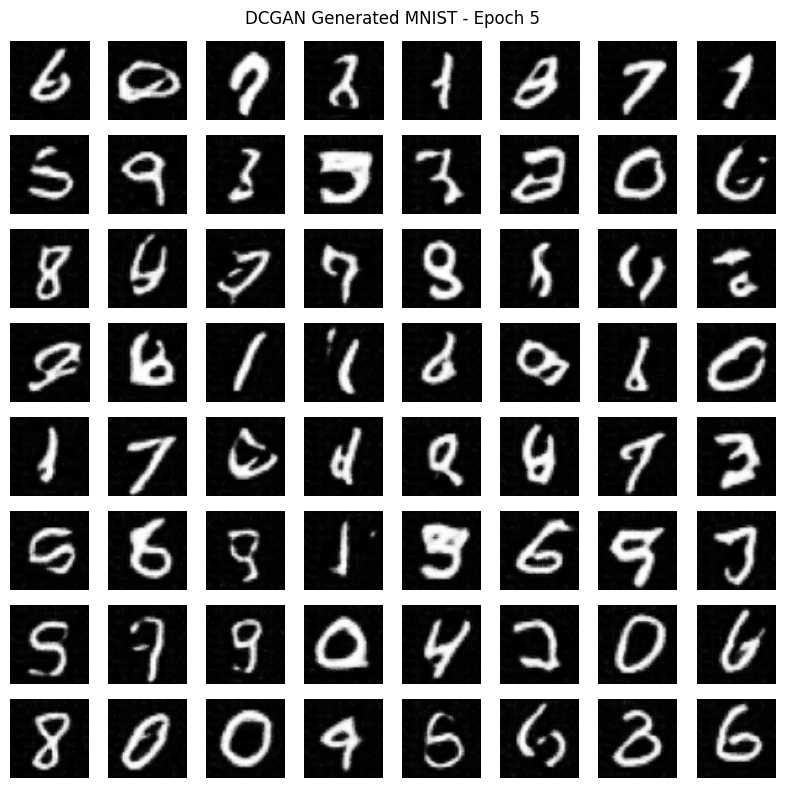

Epoch 6/25:   0%|          | 2/469 [00:00<01:58,  3.93it/s]

[6/25][0/469] Loss_D: 0.1058 Loss_G: 4.1340 D(x): 0.9630 D(G(z)): 0.0634 / 0.0248


Epoch 6/25:  11%|█         | 52/469 [00:08<01:06,  6.25it/s]

[6/25][50/469] Loss_D: 0.8467 Loss_G: 1.7404 D(x): 0.4906 D(G(z)): 0.0046 / 0.2455


Epoch 6/25:  22%|██▏       | 102/469 [00:16<00:59,  6.17it/s]

[6/25][100/469] Loss_D: 0.2828 Loss_G: 2.0577 D(x): 0.8124 D(G(z)): 0.0506 / 0.1681


Epoch 6/25:  32%|███▏      | 152/469 [00:24<00:51,  6.15it/s]

[6/25][150/469] Loss_D: 0.6662 Loss_G: 2.8303 D(x): 0.7149 D(G(z)): 0.2286 / 0.0909


Epoch 6/25:  43%|████▎     | 202/469 [00:32<00:42,  6.27it/s]

[6/25][200/469] Loss_D: 1.2695 Loss_G: 1.0600 D(x): 0.4023 D(G(z)): 0.1332 / 0.4066


Epoch 6/25:  54%|█████▎    | 252/469 [00:40<00:35,  6.16it/s]

[6/25][250/469] Loss_D: 0.2443 Loss_G: 2.3528 D(x): 0.9469 D(G(z)): 0.1616 / 0.1339


Epoch 6/25:  64%|██████▍   | 302/469 [00:48<00:27,  6.03it/s]

[6/25][300/469] Loss_D: 0.1218 Loss_G: 3.1842 D(x): 0.9249 D(G(z)): 0.0380 / 0.0619


Epoch 6/25:  75%|███████▌  | 352/469 [00:57<00:19,  6.16it/s]

[6/25][350/469] Loss_D: 0.0729 Loss_G: 4.0050 D(x): 0.9647 D(G(z)): 0.0345 / 0.0265


Epoch 6/25:  86%|████████▌ | 402/469 [01:05<00:10,  6.20it/s]

[6/25][400/469] Loss_D: 0.6033 Loss_G: 2.4468 D(x): 0.6860 D(G(z)): 0.1380 / 0.1268


Epoch 6/25:  96%|█████████▋| 452/469 [01:13<00:02,  6.23it/s]

[6/25][450/469] Loss_D: 1.1213 Loss_G: 6.7542 D(x): 0.9913 D(G(z)): 0.6226 / 0.0017


Epoch 6/25: 100%|██████████| 469/469 [01:16<00:00,  6.17it/s]



Epoch 6 Summary:
  Average D Loss: 0.5312
  Average G Loss: 3.3911
  Final D(x): 0.6170
  Final D(G(z)): 0.0643


Epoch 7/25:   0%|          | 2/469 [00:00<01:36,  4.85it/s]

[7/25][0/469] Loss_D: 0.2860 Loss_G: 2.3415 D(x): 0.8676 D(G(z)): 0.1121 / 0.1275


Epoch 7/25:  11%|█         | 52/469 [00:08<01:06,  6.29it/s]

[7/25][50/469] Loss_D: 0.2725 Loss_G: 2.9646 D(x): 0.8030 D(G(z)): 0.0260 / 0.0784


Epoch 7/25:  22%|██▏       | 102/469 [00:16<00:58,  6.23it/s]

[7/25][100/469] Loss_D: 0.2443 Loss_G: 3.3237 D(x): 0.8570 D(G(z)): 0.0720 / 0.0558


Epoch 7/25:  32%|███▏      | 152/469 [00:24<00:51,  6.11it/s]

[7/25][150/469] Loss_D: 0.2972 Loss_G: 3.5588 D(x): 0.8552 D(G(z)): 0.1109 / 0.0404


Epoch 7/25:  43%|████▎     | 202/469 [00:32<00:42,  6.28it/s]

[7/25][200/469] Loss_D: 0.1663 Loss_G: 4.2787 D(x): 0.9180 D(G(z)): 0.0697 / 0.0212


Epoch 7/25:  54%|█████▎    | 252/469 [00:40<00:34,  6.23it/s]

[7/25][250/469] Loss_D: 0.0658 Loss_G: 4.2192 D(x): 0.9558 D(G(z)): 0.0192 / 0.0221


Epoch 7/25:  64%|██████▍   | 302/469 [00:48<00:27,  6.10it/s]

[7/25][300/469] Loss_D: 0.1310 Loss_G: 4.7213 D(x): 0.9869 D(G(z)): 0.1063 / 0.0123


Epoch 7/25:  75%|███████▌  | 352/469 [00:56<00:19,  6.12it/s]

[7/25][350/469] Loss_D: 0.7545 Loss_G: 2.1997 D(x): 0.8145 D(G(z)): 0.3791 / 0.1368


Epoch 7/25:  86%|████████▌ | 402/469 [01:04<00:10,  6.25it/s]

[7/25][400/469] Loss_D: 1.2726 Loss_G: 5.6980 D(x): 0.9942 D(G(z)): 0.6252 / 0.0060


Epoch 7/25:  96%|█████████▋| 452/469 [01:13<00:02,  6.12it/s]

[7/25][450/469] Loss_D: 0.1862 Loss_G: 4.0307 D(x): 0.9106 D(G(z)): 0.0796 / 0.0281


Epoch 7/25: 100%|██████████| 469/469 [01:15<00:00,  6.19it/s]



Epoch 7 Summary:
  Average D Loss: 0.4496
  Average G Loss: 3.4850
  Final D(x): 0.9259
  Final D(G(z)): 0.0533


Epoch 8/25:   0%|          | 2/469 [00:00<01:38,  4.76it/s]

[8/25][0/469] Loss_D: 0.1542 Loss_G: 3.7355 D(x): 0.9442 D(G(z)): 0.0851 / 0.0372


Epoch 8/25:  11%|█         | 52/469 [00:08<01:07,  6.21it/s]

[8/25][50/469] Loss_D: 0.4201 Loss_G: 3.6887 D(x): 0.9166 D(G(z)): 0.2577 / 0.0348


Epoch 8/25:  22%|██▏       | 102/469 [00:16<00:59,  6.21it/s]

[8/25][100/469] Loss_D: 0.2466 Loss_G: 3.4682 D(x): 0.8965 D(G(z)): 0.1101 / 0.0417


Epoch 8/25:  32%|███▏      | 152/469 [00:24<00:51,  6.17it/s]

[8/25][150/469] Loss_D: 0.2218 Loss_G: 2.8342 D(x): 0.8799 D(G(z)): 0.0783 / 0.0790


Epoch 8/25:  43%|████▎     | 202/469 [00:32<00:42,  6.25it/s]

[8/25][200/469] Loss_D: 0.0783 Loss_G: 3.7865 D(x): 0.9479 D(G(z)): 0.0226 / 0.0324


Epoch 8/25:  54%|█████▎    | 252/469 [00:40<00:34,  6.25it/s]

[8/25][250/469] Loss_D: 0.6540 Loss_G: 3.9485 D(x): 0.7123 D(G(z)): 0.1962 / 0.0327


Epoch 8/25:  64%|██████▍   | 302/469 [00:49<00:27,  6.15it/s]

[8/25][300/469] Loss_D: 0.9061 Loss_G: 2.6607 D(x): 0.6259 D(G(z)): 0.2386 / 0.1111


Epoch 8/25:  75%|███████▌  | 352/469 [00:57<00:19,  6.13it/s]

[8/25][350/469] Loss_D: 1.3750 Loss_G: 1.8178 D(x): 0.3325 D(G(z)): 0.0064 / 0.2221


Epoch 8/25:  86%|████████▌ | 402/469 [01:05<00:10,  6.19it/s]

[8/25][400/469] Loss_D: 0.5764 Loss_G: 4.1628 D(x): 0.9781 D(G(z)): 0.3731 / 0.0239


Epoch 8/25:  96%|█████████▋| 452/469 [01:13<00:02,  6.22it/s]

[8/25][450/469] Loss_D: 0.0917 Loss_G: 4.2252 D(x): 0.9579 D(G(z)): 0.0454 / 0.0223


Epoch 8/25: 100%|██████████| 469/469 [01:16<00:00,  6.17it/s]



Epoch 8 Summary:
  Average D Loss: 0.4738
  Average G Loss: 3.4527
  Final D(x): 0.9762
  Final D(G(z)): 0.0131


Epoch 9/25:   0%|          | 2/469 [00:00<01:39,  4.67it/s]

[9/25][0/469] Loss_D: 0.0525 Loss_G: 4.7161 D(x): 0.9634 D(G(z)): 0.0141 / 0.0164


Epoch 9/25:  11%|█         | 52/469 [00:08<01:07,  6.19it/s]

[9/25][50/469] Loss_D: 0.0411 Loss_G: 4.9800 D(x): 0.9725 D(G(z)): 0.0127 / 0.0113


Epoch 9/25:  22%|██▏       | 102/469 [00:16<00:58,  6.26it/s]

[9/25][100/469] Loss_D: 0.6399 Loss_G: 1.9878 D(x): 0.7495 D(G(z)): 0.2585 / 0.1752


Epoch 9/25:  32%|███▏      | 152/469 [00:24<00:50,  6.22it/s]

[9/25][150/469] Loss_D: 0.4246 Loss_G: 2.2682 D(x): 0.8341 D(G(z)): 0.1785 / 0.1568


Epoch 9/25:  43%|████▎     | 202/469 [00:32<00:43,  6.15it/s]

[9/25][200/469] Loss_D: 0.2629 Loss_G: 4.2002 D(x): 0.9336 D(G(z)): 0.1621 / 0.0223


Epoch 9/25:  54%|█████▎    | 252/469 [00:40<00:34,  6.22it/s]

[9/25][250/469] Loss_D: 0.7396 Loss_G: 2.5599 D(x): 0.6974 D(G(z)): 0.2430 / 0.1120


Epoch 9/25:  64%|██████▍   | 302/469 [00:48<00:27,  6.16it/s]

[9/25][300/469] Loss_D: 1.7894 Loss_G: 1.2119 D(x): 0.2364 D(G(z)): 0.0010 / 0.4290


Epoch 9/25:  75%|███████▌  | 352/469 [00:56<00:18,  6.20it/s]

[9/25][350/469] Loss_D: 0.3582 Loss_G: 6.7163 D(x): 0.9253 D(G(z)): 0.2137 / 0.0019


Epoch 9/25:  86%|████████▌ | 402/469 [01:05<00:10,  6.21it/s]

[9/25][400/469] Loss_D: 0.1172 Loss_G: 3.8751 D(x): 0.9547 D(G(z)): 0.0645 / 0.0313


Epoch 9/25:  96%|█████████▋| 452/469 [01:13<00:02,  6.26it/s]

[9/25][450/469] Loss_D: 0.0989 Loss_G: 4.4927 D(x): 0.9610 D(G(z)): 0.0534 / 0.0172


Epoch 9/25: 100%|██████████| 469/469 [01:15<00:00,  6.19it/s]



Epoch 9 Summary:
  Average D Loss: 0.4368
  Average G Loss: 3.5342
  Final D(x): 0.9711
  Final D(G(z)): 0.0146


Epoch 10/25:   0%|          | 2/469 [00:00<01:38,  4.72it/s]

[10/25][0/469] Loss_D: 0.0651 Loss_G: 5.1635 D(x): 0.9937 D(G(z)): 0.0534 / 0.0098


Epoch 10/25:  11%|█         | 52/469 [00:08<01:08,  6.07it/s]

[10/25][50/469] Loss_D: 0.0512 Loss_G: 4.3249 D(x): 0.9851 D(G(z)): 0.0345 / 0.0199


Epoch 10/25:  22%|██▏       | 102/469 [00:16<00:58,  6.22it/s]

[10/25][100/469] Loss_D: 1.4481 Loss_G: 0.6364 D(x): 0.3845 D(G(z)): 0.2721 / 0.5632


Epoch 10/25:  32%|███▏      | 152/469 [00:24<00:50,  6.25it/s]

[10/25][150/469] Loss_D: 0.5187 Loss_G: 1.7843 D(x): 0.7136 D(G(z)): 0.1254 / 0.2175


Epoch 10/25:  43%|████▎     | 202/469 [00:32<00:43,  6.09it/s]

[10/25][200/469] Loss_D: 0.3375 Loss_G: 1.6581 D(x): 0.7735 D(G(z)): 0.0435 / 0.2520


Epoch 10/25:  54%|█████▎    | 252/469 [00:40<00:34,  6.20it/s]

[10/25][250/469] Loss_D: 0.5404 Loss_G: 2.6932 D(x): 0.8559 D(G(z)): 0.2747 / 0.0921


Epoch 10/25:  64%|██████▍   | 302/469 [00:48<00:27,  6.14it/s]

[10/25][300/469] Loss_D: 0.9164 Loss_G: 2.1518 D(x): 0.7899 D(G(z)): 0.4465 / 0.1451


Epoch 10/25:  75%|███████▌  | 352/469 [00:57<00:19,  6.03it/s]

[10/25][350/469] Loss_D: 0.2526 Loss_G: 2.9272 D(x): 0.8343 D(G(z)): 0.0456 / 0.0797


Epoch 10/25:  86%|████████▌ | 402/469 [01:05<00:10,  6.24it/s]

[10/25][400/469] Loss_D: 0.1411 Loss_G: 4.4840 D(x): 0.9745 D(G(z)): 0.1038 / 0.0162


Epoch 10/25:  96%|█████████▋| 452/469 [01:13<00:02,  6.22it/s]

[10/25][450/469] Loss_D: 1.2837 Loss_G: 6.2653 D(x): 0.9942 D(G(z)): 0.6307 / 0.0034


Epoch 10/25: 100%|██████████| 469/469 [01:15<00:00,  6.17it/s]



Epoch 10 Summary:
  Average D Loss: 0.5906
  Average G Loss: 3.2770
  Final D(x): 0.9149
  Final D(G(z)): 0.0551

Generating images at epoch 10...


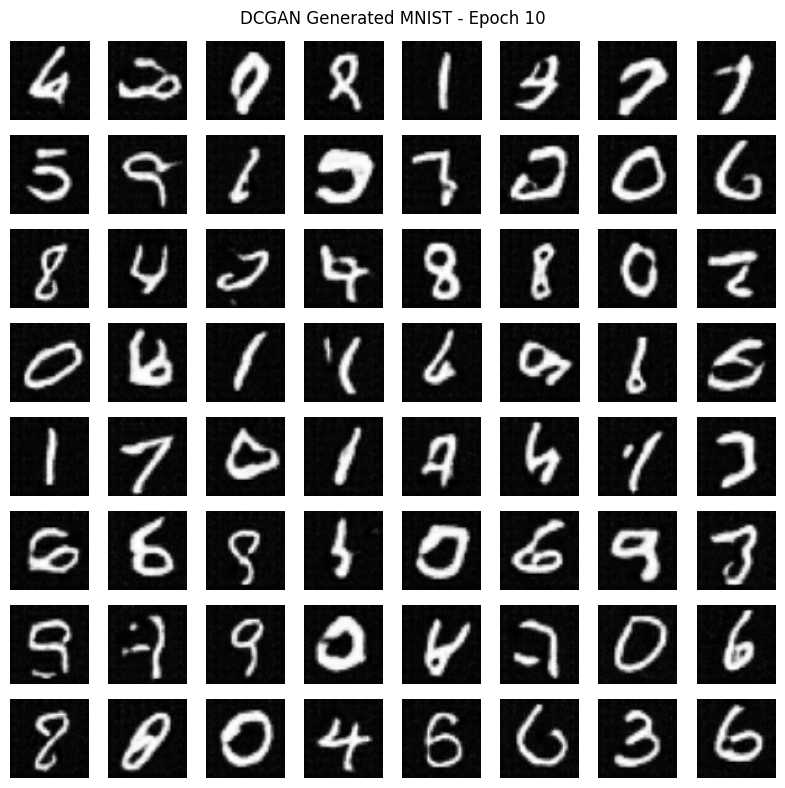

Epoch 11/25:   0%|          | 2/469 [00:00<01:48,  4.32it/s]

[11/25][0/469] Loss_D: 0.2853 Loss_G: 4.0684 D(x): 0.9415 D(G(z)): 0.1829 / 0.0243


Epoch 11/25:  11%|█         | 52/469 [00:08<01:07,  6.18it/s]

[11/25][50/469] Loss_D: 0.0803 Loss_G: 3.9720 D(x): 0.9538 D(G(z)): 0.0307 / 0.0261


Epoch 11/25:  22%|██▏       | 102/469 [00:16<01:00,  6.08it/s]

[11/25][100/469] Loss_D: 0.0440 Loss_G: 4.2301 D(x): 0.9682 D(G(z)): 0.0096 / 0.0228


Epoch 11/25:  32%|███▏      | 152/469 [00:24<00:51,  6.21it/s]

[11/25][150/469] Loss_D: 0.5104 Loss_G: 2.5405 D(x): 0.7914 D(G(z)): 0.2169 / 0.0960


Epoch 11/25:  43%|████▎     | 202/469 [00:32<00:43,  6.14it/s]

[11/25][200/469] Loss_D: 0.1926 Loss_G: 5.2403 D(x): 0.9714 D(G(z)): 0.1380 / 0.0081


Epoch 11/25:  54%|█████▎    | 252/469 [00:41<00:35,  6.10it/s]

[11/25][250/469] Loss_D: 1.3261 Loss_G: 2.1931 D(x): 0.3470 D(G(z)): 0.0179 / 0.1732


Epoch 11/25:  64%|██████▍   | 302/469 [00:49<00:27,  6.13it/s]

[11/25][300/469] Loss_D: 0.8020 Loss_G: 0.9179 D(x): 0.5260 D(G(z)): 0.0628 / 0.4522


Epoch 11/25:  75%|███████▌  | 352/469 [00:57<00:18,  6.17it/s]

[11/25][350/469] Loss_D: 1.0226 Loss_G: 1.5491 D(x): 0.4886 D(G(z)): 0.1233 / 0.2881


Epoch 11/25:  86%|████████▌ | 402/469 [01:05<00:10,  6.26it/s]

[11/25][400/469] Loss_D: 0.1507 Loss_G: 3.5334 D(x): 0.9339 D(G(z)): 0.0743 / 0.0406


Epoch 11/25:  96%|█████████▋| 452/469 [01:13<00:02,  6.16it/s]

[11/25][450/469] Loss_D: 0.7513 Loss_G: 6.3239 D(x): 0.9940 D(G(z)): 0.4530 / 0.0032


Epoch 11/25: 100%|██████████| 469/469 [01:16<00:00,  6.15it/s]



Epoch 11 Summary:
  Average D Loss: 0.4804
  Average G Loss: 3.4906
  Final D(x): 0.9486
  Final D(G(z)): 0.0070


Epoch 12/25:   0%|          | 2/469 [00:00<01:39,  4.71it/s]

[12/25][0/469] Loss_D: 1.9379 Loss_G: 0.4741 D(x): 0.2122 D(G(z)): 0.0481 / 0.6856


Epoch 12/25:  11%|█         | 52/469 [00:08<01:07,  6.18it/s]

[12/25][50/469] Loss_D: 0.3241 Loss_G: 3.4494 D(x): 0.9719 D(G(z)): 0.2352 / 0.0437


Epoch 12/25:  22%|██▏       | 102/469 [00:16<01:01,  5.97it/s]

[12/25][100/469] Loss_D: 0.0672 Loss_G: 3.7504 D(x): 0.9578 D(G(z)): 0.0227 / 0.0344


Epoch 12/25:  32%|███▏      | 152/469 [00:24<00:50,  6.22it/s]

[12/25][150/469] Loss_D: 0.2485 Loss_G: 2.5023 D(x): 0.8169 D(G(z)): 0.0239 / 0.1245


Epoch 12/25:  43%|████▎     | 202/469 [00:32<00:42,  6.24it/s]

[12/25][200/469] Loss_D: 0.0446 Loss_G: 4.1328 D(x): 0.9696 D(G(z)): 0.0129 / 0.0234


Epoch 12/25:  54%|█████▎    | 252/469 [00:40<00:35,  6.03it/s]

[12/25][250/469] Loss_D: 0.0646 Loss_G: 3.7585 D(x): 0.9466 D(G(z)): 0.0077 / 0.0381


Epoch 12/25:  64%|██████▍   | 302/469 [00:48<00:26,  6.24it/s]

[12/25][300/469] Loss_D: 0.0428 Loss_G: 4.4587 D(x): 0.9782 D(G(z)): 0.0199 / 0.0184


Epoch 12/25:  75%|███████▌  | 352/469 [00:56<00:18,  6.23it/s]

[12/25][350/469] Loss_D: 1.0572 Loss_G: 1.2707 D(x): 0.6214 D(G(z)): 0.3655 / 0.3222


Epoch 12/25:  86%|████████▌ | 402/469 [01:05<00:10,  6.13it/s]

[12/25][400/469] Loss_D: 0.4869 Loss_G: 1.8716 D(x): 0.7233 D(G(z)): 0.1055 / 0.2013


Epoch 12/25:  96%|█████████▋| 452/469 [01:13<00:02,  6.11it/s]

[12/25][450/469] Loss_D: 0.5922 Loss_G: 2.6760 D(x): 0.6813 D(G(z)): 0.1112 / 0.1067


Epoch 12/25: 100%|██████████| 469/469 [01:15<00:00,  6.18it/s]



Epoch 12 Summary:
  Average D Loss: 0.3842
  Average G Loss: 3.7625
  Final D(x): 0.9356
  Final D(G(z)): 0.0277


Epoch 13/25:   0%|          | 2/469 [00:00<01:39,  4.67it/s]

[13/25][0/469] Loss_D: 0.2958 Loss_G: 3.7141 D(x): 0.8668 D(G(z)): 0.1172 / 0.0404


Epoch 13/25:  11%|█         | 52/469 [00:08<01:07,  6.17it/s]

[13/25][50/469] Loss_D: 0.3620 Loss_G: 2.5373 D(x): 0.7443 D(G(z)): 0.0243 / 0.1253


Epoch 13/25:  22%|██▏       | 102/469 [00:17<01:05,  5.61it/s]

[13/25][100/469] Loss_D: 0.9438 Loss_G: 3.2495 D(x): 0.7765 D(G(z)): 0.4346 / 0.0537


Epoch 13/25:  32%|███▏      | 152/469 [00:25<00:50,  6.27it/s]

[13/25][150/469] Loss_D: 0.3188 Loss_G: 4.3353 D(x): 0.9578 D(G(z)): 0.2222 / 0.0185


Epoch 13/25:  43%|████▎     | 202/469 [00:33<00:43,  6.18it/s]

[13/25][200/469] Loss_D: 0.7428 Loss_G: 3.9336 D(x): 0.9729 D(G(z)): 0.4368 / 0.0327


Epoch 13/25:  54%|█████▎    | 252/469 [00:41<00:35,  6.06it/s]

[13/25][250/469] Loss_D: 0.1859 Loss_G: 4.1014 D(x): 0.9656 D(G(z)): 0.1326 / 0.0227


Epoch 13/25:  64%|██████▍   | 302/469 [00:49<00:27,  6.14it/s]

[13/25][300/469] Loss_D: 0.0891 Loss_G: 3.7374 D(x): 0.9351 D(G(z)): 0.0189 / 0.0376


Epoch 13/25:  75%|███████▌  | 352/469 [00:57<00:19,  6.10it/s]

[13/25][350/469] Loss_D: 0.0519 Loss_G: 4.0735 D(x): 0.9790 D(G(z)): 0.0296 / 0.0247


Epoch 13/25:  86%|████████▌ | 402/469 [01:05<00:11,  6.00it/s]

[13/25][400/469] Loss_D: 0.0298 Loss_G: 4.6970 D(x): 0.9836 D(G(z)): 0.0129 / 0.0146


Epoch 13/25:  96%|█████████▋| 452/469 [01:14<00:02,  6.11it/s]

[13/25][450/469] Loss_D: 0.0394 Loss_G: 4.7392 D(x): 0.9871 D(G(z)): 0.0254 / 0.0136


Epoch 13/25: 100%|██████████| 469/469 [01:16<00:00,  6.11it/s]



Epoch 13 Summary:
  Average D Loss: 0.3897
  Average G Loss: 3.8430
  Final D(x): 0.6359
  Final D(G(z)): 0.3339


Epoch 14/25:   0%|          | 2/469 [00:00<01:56,  4.00it/s]

[14/25][0/469] Loss_D: 1.4953 Loss_G: 0.9038 D(x): 0.4959 D(G(z)): 0.3863 / 0.4451


Epoch 14/25:  11%|█         | 52/469 [00:08<01:09,  6.03it/s]

[14/25][50/469] Loss_D: 0.5037 Loss_G: 2.6900 D(x): 0.8279 D(G(z)): 0.2334 / 0.0922


Epoch 14/25:  22%|██▏       | 102/469 [00:16<00:59,  6.17it/s]

[14/25][100/469] Loss_D: 0.2365 Loss_G: 3.2276 D(x): 0.8736 D(G(z)): 0.0790 / 0.0621


Epoch 14/25:  32%|███▏      | 152/469 [00:25<00:51,  6.16it/s]

[14/25][150/469] Loss_D: 0.1336 Loss_G: 3.6130 D(x): 0.9156 D(G(z)): 0.0391 / 0.0372


Epoch 14/25:  43%|████▎     | 202/469 [00:33<00:43,  6.15it/s]

[14/25][200/469] Loss_D: 0.4076 Loss_G: 2.2820 D(x): 0.8633 D(G(z)): 0.2033 / 0.1310


Epoch 14/25:  54%|█████▎    | 252/469 [00:41<00:34,  6.26it/s]

[14/25][250/469] Loss_D: 0.3947 Loss_G: 2.9966 D(x): 0.7702 D(G(z)): 0.0936 / 0.0765


Epoch 14/25:  64%|██████▍   | 302/469 [00:49<00:27,  6.13it/s]

[14/25][300/469] Loss_D: 1.5693 Loss_G: 6.1472 D(x): 0.9930 D(G(z)): 0.6813 / 0.0045


Epoch 14/25:  75%|███████▌  | 352/469 [00:57<00:18,  6.30it/s]

[14/25][350/469] Loss_D: 0.2639 Loss_G: 3.4277 D(x): 0.8729 D(G(z)): 0.0973 / 0.0467


Epoch 14/25:  86%|████████▌ | 402/469 [01:05<00:11,  6.09it/s]

[14/25][400/469] Loss_D: 0.0745 Loss_G: 4.9260 D(x): 0.9850 D(G(z)): 0.0551 / 0.0114


Epoch 14/25:  96%|█████████▋| 452/469 [01:13<00:02,  6.12it/s]

[14/25][450/469] Loss_D: 0.0545 Loss_G: 4.7699 D(x): 0.9859 D(G(z)): 0.0385 / 0.0128


Epoch 14/25: 100%|██████████| 469/469 [01:16<00:00,  6.14it/s]



Epoch 14 Summary:
  Average D Loss: 0.5743
  Average G Loss: 3.2230
  Final D(x): 0.8197
  Final D(G(z)): 0.0937


Epoch 15/25:   0%|          | 2/469 [00:00<02:02,  3.81it/s]

[15/25][0/469] Loss_D: 0.5396 Loss_G: 1.9769 D(x): 0.7191 D(G(z)): 0.1514 / 0.1871


Epoch 15/25:  11%|█         | 52/469 [00:08<01:07,  6.20it/s]

[15/25][50/469] Loss_D: 0.1553 Loss_G: 3.9828 D(x): 0.9257 D(G(z)): 0.0678 / 0.0285


Epoch 15/25:  22%|██▏       | 102/469 [00:16<00:59,  6.17it/s]

[15/25][100/469] Loss_D: 0.5130 Loss_G: 0.9110 D(x): 0.6429 D(G(z)): 0.0070 / 0.4730


Epoch 15/25:  32%|███▏      | 152/469 [00:24<00:50,  6.25it/s]

[15/25][150/469] Loss_D: 1.1149 Loss_G: 1.3401 D(x): 0.3831 D(G(z)): 0.0097 / 0.3496


Epoch 15/25:  43%|████▎     | 202/469 [00:32<00:43,  6.15it/s]

[15/25][200/469] Loss_D: 0.4919 Loss_G: 5.0436 D(x): 0.9914 D(G(z)): 0.3401 / 0.0091


Epoch 15/25:  54%|█████▎    | 252/469 [00:41<00:34,  6.25it/s]

[15/25][250/469] Loss_D: 0.1587 Loss_G: 4.8136 D(x): 0.9750 D(G(z)): 0.1180 / 0.0118


Epoch 15/25:  64%|██████▍   | 302/469 [00:49<00:26,  6.20it/s]

[15/25][300/469] Loss_D: 0.0233 Loss_G: 5.2650 D(x): 0.9851 D(G(z)): 0.0081 / 0.0083


Epoch 15/25:  75%|███████▌  | 352/469 [00:57<00:18,  6.20it/s]

[15/25][350/469] Loss_D: 0.0452 Loss_G: 5.5894 D(x): 0.9828 D(G(z)): 0.0260 / 0.0063


Epoch 15/25:  86%|████████▌ | 402/469 [01:05<00:10,  6.15it/s]

[15/25][400/469] Loss_D: 0.0330 Loss_G: 4.6149 D(x): 0.9844 D(G(z)): 0.0169 / 0.0146


Epoch 15/25:  96%|█████████▋| 452/469 [01:13<00:02,  6.25it/s]

[15/25][450/469] Loss_D: 0.0228 Loss_G: 4.8368 D(x): 0.9846 D(G(z)): 0.0070 / 0.0139


Epoch 15/25: 100%|██████████| 469/469 [01:16<00:00,  6.16it/s]



Epoch 15 Summary:
  Average D Loss: 0.2775
  Average G Loss: 4.1598
  Final D(x): 0.9733
  Final D(G(z)): 0.0146

Generating images at epoch 15...


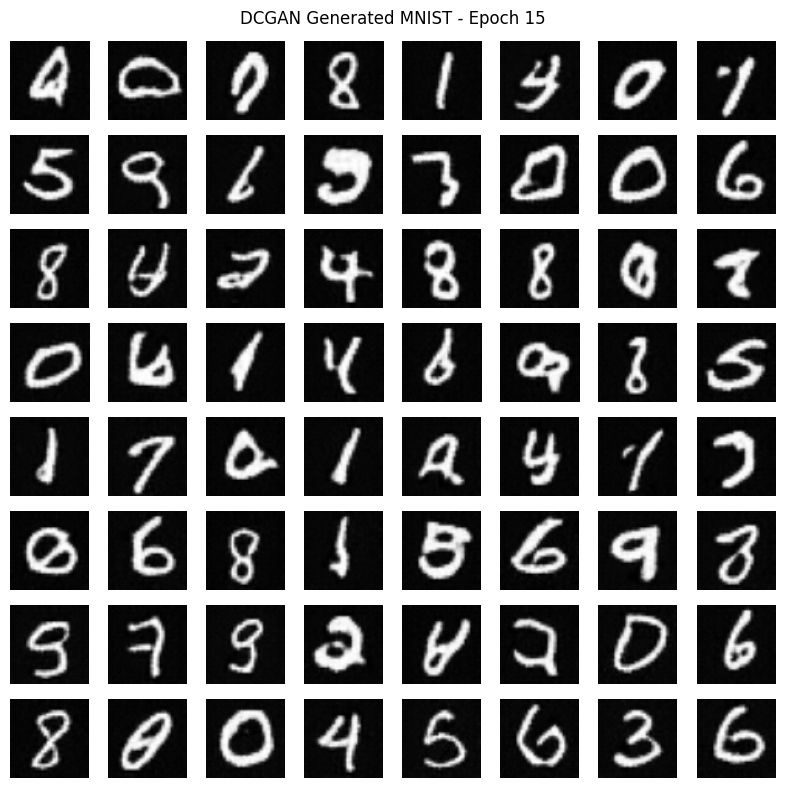

Epoch 16/25:   0%|          | 2/469 [00:00<01:52,  4.15it/s]

[16/25][0/469] Loss_D: 0.0198 Loss_G: 5.2004 D(x): 0.9923 D(G(z)): 0.0119 / 0.0098


Epoch 16/25:  11%|█         | 52/469 [00:08<01:06,  6.22it/s]

[16/25][50/469] Loss_D: 0.0246 Loss_G: 5.3145 D(x): 0.9836 D(G(z)): 0.0079 / 0.0077


Epoch 16/25:  22%|██▏       | 102/469 [00:16<00:58,  6.25it/s]

[16/25][100/469] Loss_D: 0.0348 Loss_G: 4.5982 D(x): 0.9744 D(G(z)): 0.0084 / 0.0164


Epoch 16/25:  32%|███▏      | 152/469 [00:24<00:52,  6.08it/s]

[16/25][150/469] Loss_D: 0.7858 Loss_G: 2.2401 D(x): 0.8289 D(G(z)): 0.4112 / 0.1264


Epoch 16/25:  43%|████▎     | 202/469 [00:32<00:43,  6.15it/s]

[16/25][200/469] Loss_D: 0.4156 Loss_G: 2.4167 D(x): 0.8622 D(G(z)): 0.2039 / 0.1353


Epoch 16/25:  54%|█████▎    | 252/469 [00:41<00:35,  6.12it/s]

[16/25][250/469] Loss_D: 0.4252 Loss_G: 2.2331 D(x): 0.7510 D(G(z)): 0.0762 / 0.1516


Epoch 16/25:  64%|██████▍   | 302/469 [00:49<00:27,  6.06it/s]

[16/25][300/469] Loss_D: 0.3053 Loss_G: 3.6755 D(x): 0.8990 D(G(z)): 0.1571 / 0.0387


Epoch 16/25:  75%|███████▌  | 352/469 [00:57<00:18,  6.20it/s]

[16/25][350/469] Loss_D: 1.0127 Loss_G: 1.8266 D(x): 0.7314 D(G(z)): 0.3733 / 0.2220


Epoch 16/25:  86%|████████▌ | 402/469 [01:05<00:10,  6.20it/s]

[16/25][400/469] Loss_D: 0.4684 Loss_G: 3.0666 D(x): 0.8742 D(G(z)): 0.2517 / 0.0660


Epoch 16/25:  96%|█████████▋| 452/469 [01:13<00:02,  6.16it/s]

[16/25][450/469] Loss_D: 0.4116 Loss_G: 4.0352 D(x): 0.8942 D(G(z)): 0.2314 / 0.0260


Epoch 16/25: 100%|██████████| 469/469 [01:16<00:00,  6.16it/s]



Epoch 16 Summary:
  Average D Loss: 0.6063
  Average G Loss: 3.4271
  Final D(x): 0.9928
  Final D(G(z)): 0.0079


Epoch 17/25:   0%|          | 2/469 [00:00<01:40,  4.66it/s]

[17/25][0/469] Loss_D: 0.4981 Loss_G: 3.3233 D(x): 0.6912 D(G(z)): 0.0596 / 0.0617


Epoch 17/25:  11%|█         | 52/469 [00:08<01:06,  6.24it/s]

[17/25][50/469] Loss_D: 0.2251 Loss_G: 2.9586 D(x): 0.9050 D(G(z)): 0.1091 / 0.0720


Epoch 17/25:  22%|██▏       | 102/469 [00:16<00:58,  6.23it/s]

[17/25][100/469] Loss_D: 0.4904 Loss_G: 2.2110 D(x): 0.8427 D(G(z)): 0.2275 / 0.1494


Epoch 17/25:  32%|███▏      | 152/469 [00:24<00:51,  6.13it/s]

[17/25][150/469] Loss_D: 0.2876 Loss_G: 2.8647 D(x): 0.7937 D(G(z)): 0.0252 / 0.0814


Epoch 17/25:  43%|████▎     | 202/469 [00:32<00:43,  6.19it/s]

[17/25][200/469] Loss_D: 0.0626 Loss_G: 4.6454 D(x): 0.9763 D(G(z)): 0.0368 / 0.0150


Epoch 17/25:  54%|█████▎    | 252/469 [00:40<00:34,  6.22it/s]

[17/25][250/469] Loss_D: 0.0936 Loss_G: 5.8767 D(x): 0.9912 D(G(z)): 0.0781 / 0.0040


Epoch 17/25:  64%|██████▍   | 302/469 [00:48<00:27,  6.04it/s]

[17/25][300/469] Loss_D: 0.0590 Loss_G: 4.6731 D(x): 0.9695 D(G(z)): 0.0264 / 0.0154


Epoch 17/25:  75%|███████▌  | 352/469 [00:57<00:19,  6.16it/s]

[17/25][350/469] Loss_D: 0.4160 Loss_G: 1.9650 D(x): 0.7876 D(G(z)): 0.1366 / 0.1753


Epoch 17/25:  86%|████████▌ | 402/469 [01:05<00:10,  6.20it/s]

[17/25][400/469] Loss_D: 0.1923 Loss_G: 2.8210 D(x): 0.8698 D(G(z)): 0.0347 / 0.0903


Epoch 17/25:  96%|█████████▋| 452/469 [01:13<00:02,  6.14it/s]

[17/25][450/469] Loss_D: 0.1021 Loss_G: 4.0566 D(x): 0.9745 D(G(z)): 0.0691 / 0.0269


Epoch 17/25: 100%|██████████| 469/469 [01:15<00:00,  6.17it/s]



Epoch 17 Summary:
  Average D Loss: 0.4347
  Average G Loss: 3.6717
  Final D(x): 0.7545
  Final D(G(z)): 0.1626


Epoch 18/25:   0%|          | 2/469 [00:00<01:44,  4.49it/s]

[18/25][0/469] Loss_D: 0.8184 Loss_G: 2.3902 D(x): 0.7401 D(G(z)): 0.3260 / 0.1301


Epoch 18/25:  11%|█         | 52/469 [00:08<01:06,  6.29it/s]

[18/25][50/469] Loss_D: 0.0698 Loss_G: 4.1002 D(x): 0.9679 D(G(z)): 0.0350 / 0.0243


Epoch 18/25:  22%|██▏       | 102/469 [00:16<00:59,  6.21it/s]

[18/25][100/469] Loss_D: 0.0766 Loss_G: 5.2198 D(x): 0.9901 D(G(z)): 0.0621 / 0.0080


Epoch 18/25:  32%|███▏      | 152/469 [00:24<00:51,  6.18it/s]

[18/25][150/469] Loss_D: 0.0355 Loss_G: 4.8839 D(x): 0.9865 D(G(z)): 0.0211 / 0.0118


Epoch 18/25:  43%|████▎     | 202/469 [00:32<00:43,  6.15it/s]

[18/25][200/469] Loss_D: 12.3063 Loss_G: 6.0268 D(x): 0.0000 D(G(z)): 0.0000 / 0.0074


Epoch 18/25:  54%|█████▎    | 252/469 [00:41<00:34,  6.24it/s]

[18/25][250/469] Loss_D: 0.5037 Loss_G: 1.9047 D(x): 0.7200 D(G(z)): 0.1143 / 0.1976


Epoch 18/25:  64%|██████▍   | 302/469 [00:49<00:27,  6.17it/s]

[18/25][300/469] Loss_D: 0.7759 Loss_G: 1.0666 D(x): 0.5844 D(G(z)): 0.0820 / 0.4140


Epoch 18/25:  75%|███████▌  | 352/469 [00:57<00:19,  6.14it/s]

[18/25][350/469] Loss_D: 0.3905 Loss_G: 2.1998 D(x): 0.8023 D(G(z)): 0.1220 / 0.1463


Epoch 18/25:  86%|████████▌ | 402/469 [01:05<00:10,  6.22it/s]

[18/25][400/469] Loss_D: 0.9893 Loss_G: 1.2564 D(x): 0.5017 D(G(z)): 0.1394 / 0.3503


Epoch 18/25:  96%|█████████▋| 452/469 [01:13<00:02,  6.22it/s]

[18/25][450/469] Loss_D: 0.1224 Loss_G: 3.2324 D(x): 0.9298 D(G(z)): 0.0432 / 0.0619


Epoch 18/25: 100%|██████████| 469/469 [01:16<00:00,  6.15it/s]



Epoch 18 Summary:
  Average D Loss: 0.4692
  Average G Loss: 3.6746
  Final D(x): 0.9702
  Final D(G(z)): 0.0104


Epoch 19/25:   0%|          | 2/469 [00:00<01:49,  4.25it/s]

[19/25][0/469] Loss_D: 0.3964 Loss_G: 3.3691 D(x): 0.7419 D(G(z)): 0.0594 / 0.0567


Epoch 19/25:  11%|█         | 52/469 [00:08<01:07,  6.21it/s]

[19/25][50/469] Loss_D: 0.2608 Loss_G: 2.8141 D(x): 0.8672 D(G(z)): 0.0964 / 0.0825


Epoch 19/25:  22%|██▏       | 102/469 [00:16<00:59,  6.13it/s]

[19/25][100/469] Loss_D: 0.0500 Loss_G: 4.7862 D(x): 0.9867 D(G(z)): 0.0351 / 0.0129


Epoch 19/25:  32%|███▏      | 152/469 [00:24<00:51,  6.12it/s]

[19/25][150/469] Loss_D: 1.3523 Loss_G: 7.2908 D(x): 0.9906 D(G(z)): 0.6764 / 0.0010


Epoch 19/25:  43%|████▎     | 202/469 [00:32<00:43,  6.20it/s]

[19/25][200/469] Loss_D: 0.0733 Loss_G: 4.2529 D(x): 0.9589 D(G(z)): 0.0297 / 0.0209


Epoch 19/25:  54%|█████▎    | 252/469 [00:41<00:35,  6.18it/s]

[19/25][250/469] Loss_D: 0.0413 Loss_G: 4.3524 D(x): 0.9725 D(G(z)): 0.0128 / 0.0204


Epoch 19/25:  64%|██████▍   | 302/469 [00:49<00:27,  6.10it/s]

[19/25][300/469] Loss_D: 0.0291 Loss_G: 4.5713 D(x): 0.9816 D(G(z)): 0.0102 / 0.0155


Epoch 19/25:  75%|███████▌  | 352/469 [00:57<00:18,  6.26it/s]

[19/25][350/469] Loss_D: 1.1352 Loss_G: 0.7736 D(x): 0.5188 D(G(z)): 0.3274 / 0.4848


Epoch 19/25:  86%|████████▌ | 402/469 [01:05<00:10,  6.10it/s]

[19/25][400/469] Loss_D: 0.9626 Loss_G: 0.8947 D(x): 0.5124 D(G(z)): 0.1735 / 0.4436


Epoch 19/25:  96%|█████████▋| 452/469 [01:13<00:02,  6.01it/s]

[19/25][450/469] Loss_D: 0.5014 Loss_G: 2.3747 D(x): 0.7693 D(G(z)): 0.1783 / 0.1246


Epoch 19/25: 100%|██████████| 469/469 [01:16<00:00,  6.15it/s]



Epoch 19 Summary:
  Average D Loss: 0.5862
  Average G Loss: 3.2891
  Final D(x): 0.8850
  Final D(G(z)): 0.1147


Epoch 20/25:   0%|          | 2/469 [00:00<01:41,  4.61it/s]

[20/25][0/469] Loss_D: 0.4425 Loss_G: 7.3097 D(x): 0.9722 D(G(z)): 0.2934 / 0.0010


Epoch 20/25:  11%|█         | 52/469 [00:08<01:07,  6.15it/s]

[20/25][50/469] Loss_D: 0.8943 Loss_G: 1.6921 D(x): 0.7148 D(G(z)): 0.3746 / 0.2190


Epoch 20/25:  22%|██▏       | 102/469 [00:16<00:58,  6.24it/s]

[20/25][100/469] Loss_D: 0.1656 Loss_G: 4.5222 D(x): 0.9679 D(G(z)): 0.1187 / 0.0148


Epoch 20/25:  32%|███▏      | 152/469 [00:24<00:51,  6.15it/s]

[20/25][150/469] Loss_D: 0.1692 Loss_G: 4.7324 D(x): 0.9645 D(G(z)): 0.1185 / 0.0119


Epoch 20/25:  43%|████▎     | 202/469 [00:32<00:43,  6.17it/s]

[20/25][200/469] Loss_D: 0.0469 Loss_G: 5.0670 D(x): 0.9893 D(G(z)): 0.0347 / 0.0097


Epoch 20/25:  54%|█████▎    | 252/469 [00:41<00:34,  6.27it/s]

[20/25][250/469] Loss_D: 0.0424 Loss_G: 4.9210 D(x): 0.9868 D(G(z)): 0.0277 / 0.0114


Epoch 20/25:  64%|██████▍   | 302/469 [00:49<00:27,  6.02it/s]

[20/25][300/469] Loss_D: 0.0374 Loss_G: 4.5923 D(x): 0.9904 D(G(z)): 0.0269 / 0.0155


Epoch 20/25:  75%|███████▌  | 352/469 [00:57<00:19,  6.13it/s]

[20/25][350/469] Loss_D: 0.0277 Loss_G: 5.1327 D(x): 0.9908 D(G(z)): 0.0179 / 0.0099


Epoch 20/25:  86%|████████▌ | 402/469 [01:05<00:10,  6.23it/s]

[20/25][400/469] Loss_D: 1.0195 Loss_G: 1.2496 D(x): 0.6727 D(G(z)): 0.4231 / 0.3197


Epoch 20/25:  96%|█████████▋| 452/469 [01:13<00:02,  6.05it/s]

[20/25][450/469] Loss_D: 0.4231 Loss_G: 2.7792 D(x): 0.8152 D(G(z)): 0.1676 / 0.0848


Epoch 20/25: 100%|██████████| 469/469 [01:16<00:00,  6.15it/s]



Epoch 20 Summary:
  Average D Loss: 0.4209
  Average G Loss: 3.7768
  Final D(x): 0.6419
  Final D(G(z)): 0.2652

Generating images at epoch 20...


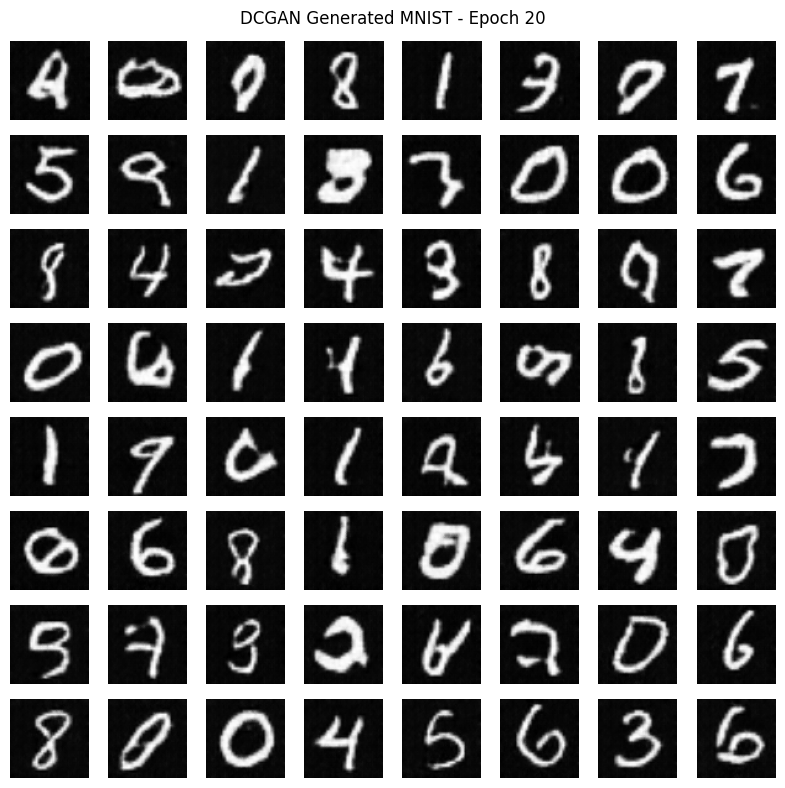

Epoch 21/25:   0%|          | 2/469 [00:00<01:46,  4.40it/s]

[21/25][0/469] Loss_D: 0.4293 Loss_G: 3.7742 D(x): 0.9493 D(G(z)): 0.2805 / 0.0350


Epoch 21/25:  11%|█         | 52/469 [00:08<01:09,  6.02it/s]

[21/25][50/469] Loss_D: 1.1128 Loss_G: 0.8148 D(x): 0.4447 D(G(z)): 0.1290 / 0.5000


Epoch 21/25:  22%|██▏       | 102/469 [00:16<00:58,  6.22it/s]

[21/25][100/469] Loss_D: 0.8787 Loss_G: 1.6942 D(x): 0.5137 D(G(z)): 0.0616 / 0.2447


Epoch 21/25:  32%|███▏      | 152/469 [00:24<00:51,  6.14it/s]

[21/25][150/469] Loss_D: 0.0619 Loss_G: 4.5317 D(x): 0.9583 D(G(z)): 0.0179 / 0.0163


Epoch 21/25:  43%|████▎     | 202/469 [00:32<00:42,  6.23it/s]

[21/25][200/469] Loss_D: 0.0401 Loss_G: 5.2329 D(x): 0.9790 D(G(z)): 0.0183 / 0.0085


Epoch 21/25:  54%|█████▎    | 252/469 [00:41<00:34,  6.23it/s]

[21/25][250/469] Loss_D: 0.6172 Loss_G: 1.9202 D(x): 0.7778 D(G(z)): 0.2647 / 0.1817


Epoch 21/25:  64%|██████▍   | 302/469 [00:49<00:27,  6.16it/s]

[21/25][300/469] Loss_D: 0.4940 Loss_G: 0.9867 D(x): 0.6716 D(G(z)): 0.0354 / 0.4523


Epoch 21/25:  75%|███████▌  | 352/469 [00:57<00:18,  6.18it/s]

[21/25][350/469] Loss_D: 0.3231 Loss_G: 2.7889 D(x): 0.7897 D(G(z)): 0.0580 / 0.0897


Epoch 21/25:  86%|████████▌ | 402/469 [01:05<00:10,  6.25it/s]

[21/25][400/469] Loss_D: 1.4331 Loss_G: 3.2787 D(x): 0.8261 D(G(z)): 0.6136 / 0.0624


Epoch 21/25:  96%|█████████▋| 452/469 [01:13<00:02,  6.02it/s]

[21/25][450/469] Loss_D: 0.2623 Loss_G: 3.4975 D(x): 0.9472 D(G(z)): 0.1663 / 0.0444


Epoch 21/25: 100%|██████████| 469/469 [01:16<00:00,  6.14it/s]



Epoch 21 Summary:
  Average D Loss: 0.5554
  Average G Loss: 3.4113
  Final D(x): 0.9797
  Final D(G(z)): 0.0164


Epoch 22/25:   0%|          | 2/469 [00:00<01:41,  4.59it/s]

[22/25][0/469] Loss_D: 0.1536 Loss_G: 3.2573 D(x): 0.9091 D(G(z)): 0.0493 / 0.0519


Epoch 22/25:  11%|█         | 52/469 [00:08<01:08,  6.09it/s]

[22/25][50/469] Loss_D: 0.1511 Loss_G: 3.6159 D(x): 0.9118 D(G(z)): 0.0517 / 0.0388


Epoch 22/25:  22%|██▏       | 102/469 [00:16<00:59,  6.14it/s]

[22/25][100/469] Loss_D: 0.0621 Loss_G: 4.1424 D(x): 0.9630 D(G(z)): 0.0232 / 0.0241


Epoch 22/25:  32%|███▏      | 152/469 [00:24<00:51,  6.16it/s]

[22/25][150/469] Loss_D: 0.0264 Loss_G: 5.0487 D(x): 0.9822 D(G(z)): 0.0082 / 0.0101


Epoch 22/25:  43%|████▎     | 202/469 [00:32<00:42,  6.21it/s]

[22/25][200/469] Loss_D: 0.0179 Loss_G: 5.2504 D(x): 0.9929 D(G(z)): 0.0107 / 0.0087


Epoch 22/25:  54%|█████▎    | 252/469 [00:41<00:35,  6.18it/s]

[22/25][250/469] Loss_D: 0.0273 Loss_G: 5.0681 D(x): 0.9863 D(G(z)): 0.0132 / 0.0102


Epoch 22/25:  64%|██████▍   | 302/469 [00:49<00:27,  6.18it/s]

[22/25][300/469] Loss_D: 0.0188 Loss_G: 4.7686 D(x): 0.9929 D(G(z)): 0.0115 / 0.0130


Epoch 22/25:  75%|███████▌  | 352/469 [00:57<00:18,  6.18it/s]

[22/25][350/469] Loss_D: 0.0187 Loss_G: 4.9853 D(x): 0.9870 D(G(z)): 0.0055 / 0.0101


Epoch 22/25:  86%|████████▌ | 402/469 [01:05<00:10,  6.15it/s]

[22/25][400/469] Loss_D: 0.0255 Loss_G: 4.9825 D(x): 0.9865 D(G(z)): 0.0114 / 0.0113


Epoch 22/25:  96%|█████████▋| 452/469 [01:13<00:02,  6.12it/s]

[22/25][450/469] Loss_D: 1.7797 Loss_G: 2.3329 D(x): 0.8559 D(G(z)): 0.7311 / 0.1398


Epoch 22/25: 100%|██████████| 469/469 [01:16<00:00,  6.15it/s]



Epoch 22 Summary:
  Average D Loss: 0.2405
  Average G Loss: 4.6704
  Final D(x): 0.5311
  Final D(G(z)): 0.3543


Epoch 23/25:   0%|          | 2/469 [00:00<01:45,  4.45it/s]

[23/25][0/469] Loss_D: 1.0157 Loss_G: 2.5834 D(x): 0.8224 D(G(z)): 0.4986 / 0.1025


Epoch 23/25:  11%|█         | 52/469 [00:08<01:07,  6.18it/s]

[23/25][50/469] Loss_D: 0.5933 Loss_G: 5.3198 D(x): 0.9809 D(G(z)): 0.3913 / 0.0070


Epoch 23/25:  22%|██▏       | 102/469 [00:16<00:58,  6.23it/s]

[23/25][100/469] Loss_D: 0.1594 Loss_G: 3.8398 D(x): 0.8866 D(G(z)): 0.0292 / 0.0349


Epoch 23/25:  32%|███▏      | 152/469 [00:24<00:51,  6.11it/s]

[23/25][150/469] Loss_D: 0.2073 Loss_G: 2.9872 D(x): 0.8763 D(G(z)): 0.0585 / 0.0751


Epoch 23/25:  43%|████▎     | 202/469 [00:32<00:43,  6.18it/s]

[23/25][200/469] Loss_D: 0.3071 Loss_G: 3.7947 D(x): 0.9554 D(G(z)): 0.2081 / 0.0307


Epoch 23/25:  54%|█████▎    | 252/469 [00:41<00:35,  6.17it/s]

[23/25][250/469] Loss_D: 0.6400 Loss_G: 1.4297 D(x): 0.6072 D(G(z)): 0.0670 / 0.3000


Epoch 23/25:  64%|██████▍   | 302/469 [00:49<00:27,  6.15it/s]

[23/25][300/469] Loss_D: 0.1191 Loss_G: 4.0675 D(x): 0.9324 D(G(z)): 0.0441 / 0.0264


Epoch 23/25:  75%|███████▌  | 352/469 [00:57<00:18,  6.23it/s]

[23/25][350/469] Loss_D: 1.1028 Loss_G: 1.0323 D(x): 0.5797 D(G(z)): 0.3344 / 0.4107


Epoch 23/25:  86%|████████▌ | 402/469 [01:05<00:10,  6.24it/s]

[23/25][400/469] Loss_D: 1.2620 Loss_G: 0.8419 D(x): 0.3516 D(G(z)): 0.0052 / 0.5015


Epoch 23/25:  96%|█████████▋| 452/469 [01:13<00:02,  5.90it/s]

[23/25][450/469] Loss_D: 0.2860 Loss_G: 2.4190 D(x): 0.8082 D(G(z)): 0.0506 / 0.1206


Epoch 23/25: 100%|██████████| 469/469 [01:16<00:00,  6.16it/s]



Epoch 23 Summary:
  Average D Loss: 0.6034
  Average G Loss: 3.2368
  Final D(x): 0.9741
  Final D(G(z)): 0.0212


Epoch 24/25:   0%|          | 2/469 [00:00<01:47,  4.34it/s]

[24/25][0/469] Loss_D: 0.0785 Loss_G: 3.9593 D(x): 0.9521 D(G(z)): 0.0268 / 0.0306


Epoch 24/25:  11%|█         | 52/469 [00:08<01:05,  6.32it/s]

[24/25][50/469] Loss_D: 0.0390 Loss_G: 4.6810 D(x): 0.9781 D(G(z)): 0.0160 / 0.0144


Epoch 24/25:  22%|██▏       | 102/469 [00:16<00:58,  6.25it/s]

[24/25][100/469] Loss_D: 0.0230 Loss_G: 5.3166 D(x): 0.9867 D(G(z)): 0.0094 / 0.0072


Epoch 24/25:  32%|███▏      | 152/469 [00:24<00:51,  6.11it/s]

[24/25][150/469] Loss_D: 0.0285 Loss_G: 4.9742 D(x): 0.9892 D(G(z)): 0.0173 / 0.0102


Epoch 24/25:  43%|████▎     | 202/469 [00:32<00:43,  6.18it/s]

[24/25][200/469] Loss_D: 0.7812 Loss_G: 0.3750 D(x): 0.6819 D(G(z)): 0.2143 / 0.7173


Epoch 24/25:  54%|█████▎    | 252/469 [00:40<00:35,  6.14it/s]

[24/25][250/469] Loss_D: 0.1183 Loss_G: 3.4124 D(x): 0.9134 D(G(z)): 0.0220 / 0.0488


Epoch 24/25:  64%|██████▍   | 302/469 [00:49<00:28,  5.89it/s]

[24/25][300/469] Loss_D: 0.0839 Loss_G: 3.0702 D(x): 0.9324 D(G(z)): 0.0115 / 0.0657


Epoch 24/25:  75%|███████▌  | 352/469 [00:57<00:20,  5.75it/s]

[24/25][350/469] Loss_D: 0.0257 Loss_G: 5.0150 D(x): 0.9912 D(G(z)): 0.0165 / 0.0103


Epoch 24/25:  86%|████████▌ | 402/469 [01:05<00:10,  6.16it/s]

[24/25][400/469] Loss_D: 0.0203 Loss_G: 5.1846 D(x): 0.9848 D(G(z)): 0.0047 / 0.0083


Epoch 24/25:  96%|█████████▋| 452/469 [01:13<00:02,  5.99it/s]

[24/25][450/469] Loss_D: 0.0196 Loss_G: 5.1212 D(x): 0.9851 D(G(z)): 0.0044 / 0.0094


Epoch 24/25: 100%|██████████| 469/469 [01:16<00:00,  6.13it/s]



Epoch 24 Summary:
  Average D Loss: 0.1149
  Average G Loss: 4.5499
  Final D(x): 0.9886
  Final D(G(z)): 0.0031


Epoch 25/25:   0%|          | 2/469 [00:00<01:46,  4.38it/s]

[25/25][0/469] Loss_D: 0.0154 Loss_G: 5.5337 D(x): 0.9910 D(G(z)): 0.0063 / 0.0072


Epoch 25/25:  11%|█         | 52/469 [00:08<01:06,  6.25it/s]

[25/25][50/469] Loss_D: 0.0189 Loss_G: 4.9163 D(x): 0.9872 D(G(z)): 0.0059 / 0.0116


Epoch 25/25:  22%|██▏       | 102/469 [00:16<00:59,  6.22it/s]

[25/25][100/469] Loss_D: 0.0235 Loss_G: 6.7071 D(x): 0.9965 D(G(z)): 0.0186 / 0.0021


Epoch 25/25:  32%|███▏      | 152/469 [00:24<00:51,  6.11it/s]

[25/25][150/469] Loss_D: 5.6556 Loss_G: 0.0215 D(x): 0.0141 D(G(z)): 0.0100 / 0.9832


Epoch 25/25:  43%|████▎     | 202/469 [00:33<00:43,  6.14it/s]

[25/25][200/469] Loss_D: 1.1401 Loss_G: 1.2900 D(x): 0.6694 D(G(z)): 0.4790 / 0.3083


Epoch 25/25:  54%|█████▎    | 252/469 [00:41<00:35,  6.11it/s]

[25/25][250/469] Loss_D: 0.8368 Loss_G: 1.3602 D(x): 0.6535 D(G(z)): 0.2974 / 0.2917


Epoch 25/25:  64%|██████▍   | 302/469 [00:49<00:27,  6.07it/s]

[25/25][300/469] Loss_D: 0.9261 Loss_G: 1.6522 D(x): 0.6691 D(G(z)): 0.3199 / 0.2412


Epoch 25/25:  75%|███████▌  | 352/469 [00:57<00:18,  6.26it/s]

[25/25][350/469] Loss_D: 0.8740 Loss_G: 2.1691 D(x): 0.7407 D(G(z)): 0.3606 / 0.1490


Epoch 25/25:  86%|████████▌ | 402/469 [01:05<00:10,  6.19it/s]

[25/25][400/469] Loss_D: 1.0710 Loss_G: 3.7809 D(x): 0.9263 D(G(z)): 0.5435 / 0.0384


Epoch 25/25:  96%|█████████▋| 452/469 [01:13<00:02,  6.06it/s]

[25/25][450/469] Loss_D: 0.6691 Loss_G: 1.2340 D(x): 0.6128 D(G(z)): 0.0707 / 0.3827


Epoch 25/25: 100%|██████████| 469/469 [01:16<00:00,  6.14it/s]



Epoch 25 Summary:
  Average D Loss: 0.8035
  Average G Loss: 3.0692
  Final D(x): 0.8874
  Final D(G(z)): 0.0380

Generating images at epoch 25...


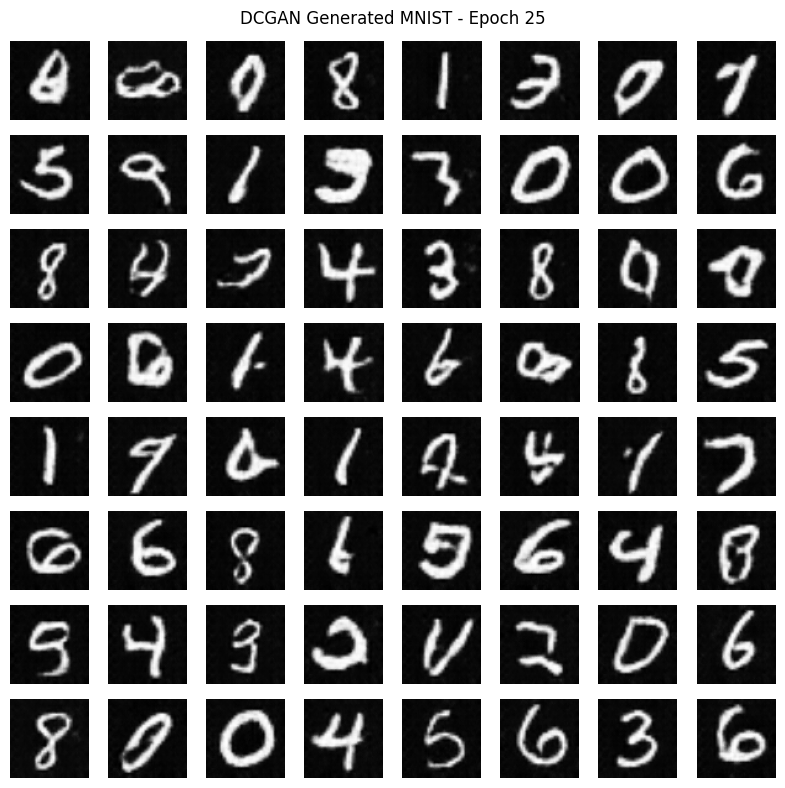


DCGAN Training completed!


In [6]:
# Training Loop
print("Starting DCGAN Training...")

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0

for epoch in range(NUM_EPOCHS):
    epoch_d_loss = 0
    epoch_g_loss = 0
    num_batches = 0

    for i, (data, _) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)

        # Calculate loss on all-real batch
        errD_real = criterion(output, label)

        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, NZ, 1, 1, device=device)

        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)

        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)

        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)

        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake

        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost

        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)

        # Calculate G's loss based on this output
        errG = criterion(output, label)

        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()

        # Update G
        optimizerG.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        epoch_d_loss += errD.item()
        epoch_g_loss += errG.item()
        num_batches += 1

        # Output training stats every 50 batches
        if i % 50 == 0:
            print(f'[{epoch+1}/{NUM_EPOCHS}][{i}/{len(dataloader)}] '
                  f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
                  f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

        iters += 1

    # Print epoch statistics
    avg_d_loss = epoch_d_loss / num_batches
    avg_g_loss = epoch_g_loss / num_batches
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Average D Loss: {avg_d_loss:.4f}")
    print(f"  Average G Loss: {avg_g_loss:.4f}")
    print(f"  Final D(x): {D_x:.4f}")
    print(f"  Final D(G(z)): {D_G_z2:.4f}")

    # Generate images every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"\nGenerating images at epoch {epoch+1}...")
        generate_and_save_images(netG, epoch+1, fixed_noise, device)

print("\nDCGAN Training completed!")

## Training Analysis: Understanding DCGAN Dynamics

Let's analyze the training progress and understand what makes DCGAN more stable:

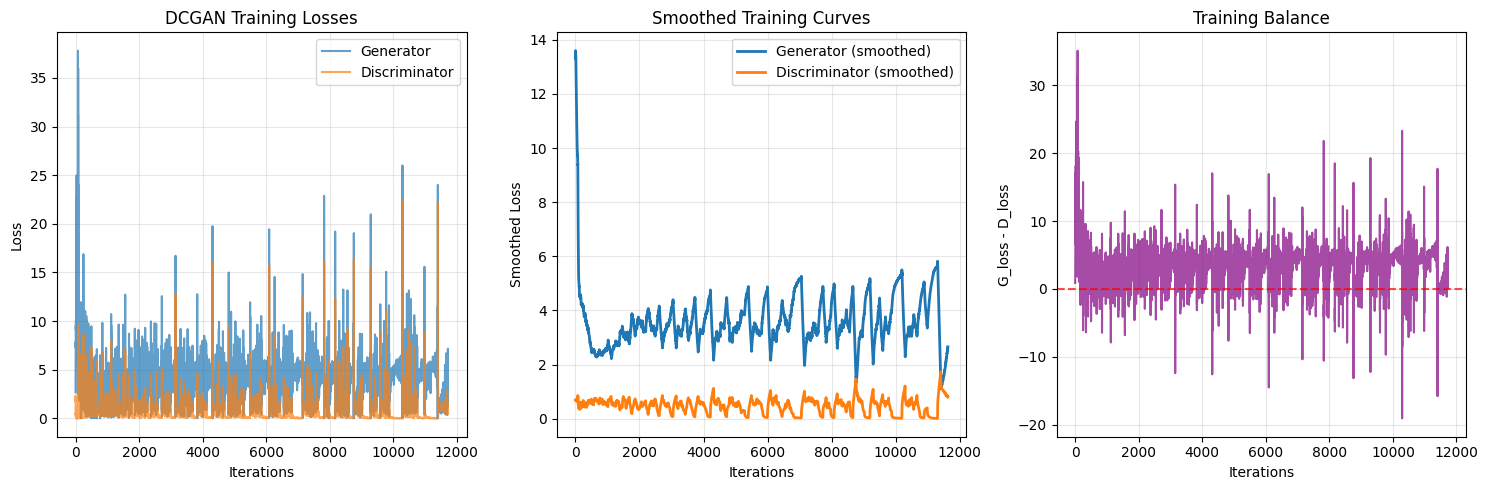

=== DCGAN Training Analysis ===
Final G Loss (avg last 100): 2.6549 ± 1.2759
Final D Loss (avg last 100): 0.8112 ± 0.4005
Loss ratio (G/D): 3.273
Total training iterations: 11,725
⚠️ Training shows some instability (high loss variance)
⚠️ Discriminator dominating (generator struggling)


In [7]:
# Plot training losses
plt.figure(figsize=(15, 5))

# Plot 1: Training losses
plt.subplot(1, 3, 1)
plt.plot(G_losses, label='Generator', alpha=0.7)
plt.plot(D_losses, label='Discriminator', alpha=0.7)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('DCGAN Training Losses')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Loss moving averages
plt.subplot(1, 3, 2)
window = 100
if len(G_losses) > window:
    g_smooth = np.convolve(G_losses, np.ones(window)/window, mode='valid')
    d_smooth = np.convolve(D_losses, np.ones(window)/window, mode='valid')
    plt.plot(g_smooth, label='Generator (smoothed)', linewidth=2)
    plt.plot(d_smooth, label='Discriminator (smoothed)', linewidth=2)
    plt.xlabel('Iterations')
    plt.ylabel('Smoothed Loss')
    plt.title('Smoothed Training Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Plot 3: Loss difference
plt.subplot(1, 3, 3)
loss_diff = np.array(G_losses) - np.array(D_losses)
plt.plot(loss_diff, alpha=0.7, color='purple')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Iterations')
plt.ylabel('G_loss - D_loss')
plt.title('Training Balance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Training analysis
final_g_loss = np.mean(G_losses[-100:])
final_d_loss = np.mean(D_losses[-100:])
loss_std_g = np.std(G_losses[-100:])
loss_std_d = np.std(D_losses[-100:])

print("=== DCGAN Training Analysis ===")
print(f"Final G Loss (avg last 100): {final_g_loss:.4f} ± {loss_std_g:.4f}")
print(f"Final D Loss (avg last 100): {final_d_loss:.4f} ± {loss_std_d:.4f}")
print(f"Loss ratio (G/D): {final_g_loss/final_d_loss:.3f}")
print(f"Total training iterations: {len(G_losses):,}")

# Stability assessment
if loss_std_g < 0.5 and loss_std_d < 0.5:
    print("✓ Training appears stable (low loss variance)")
else:
    print("⚠️ Training shows some instability (high loss variance)")

if 0.5 < final_g_loss/final_d_loss < 2.0:
    print("✓ Good balance between generator and discriminator")
elif final_g_loss/final_d_loss > 2.0:
    print("⚠️ Discriminator dominating (generator struggling)")
else:
    print("⚠️ Generator dominating (discriminator struggling)")

## Final Model Evaluation: Quality Assessment

Let's evaluate the final DCGAN model and compare it with vanilla GAN:

=== Final DCGAN Model Evaluation ===
Discriminator Performance:
  Real images score: 0.442 ± 0.242
  Fake images score: 0.305 ± 0.155
  Separation: 0.138

Sample Quality Metrics:
  Sample diversity (std): 0.5212
  Sample mean: -0.6546
  Sample range: [-0.985, 0.971]
  ✓ Good sample diversity

Generating final showcase...


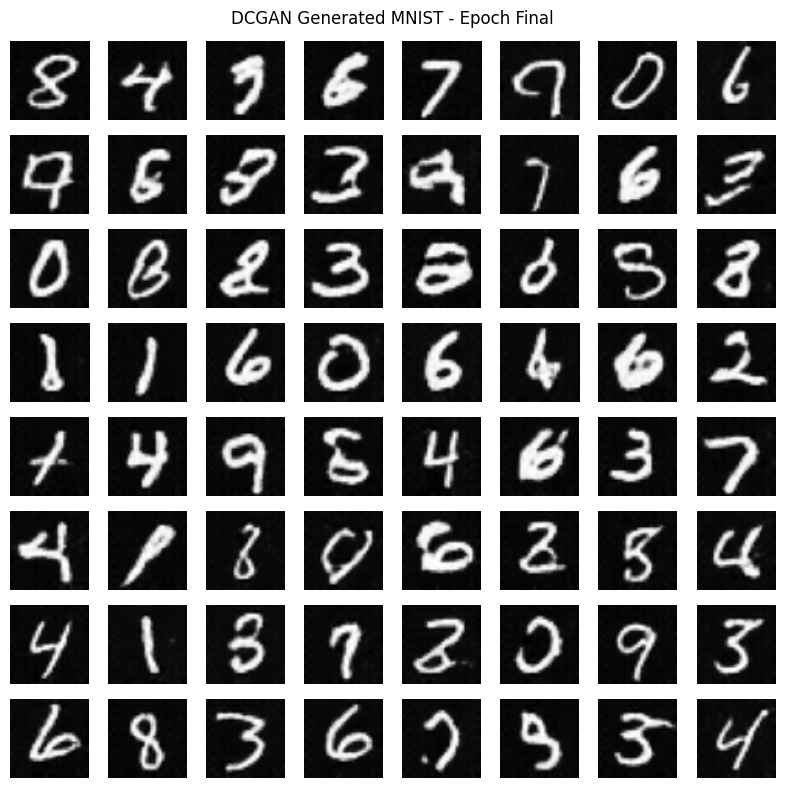

AttributeError: 'Axes' object has no attribute 'add_subplot'

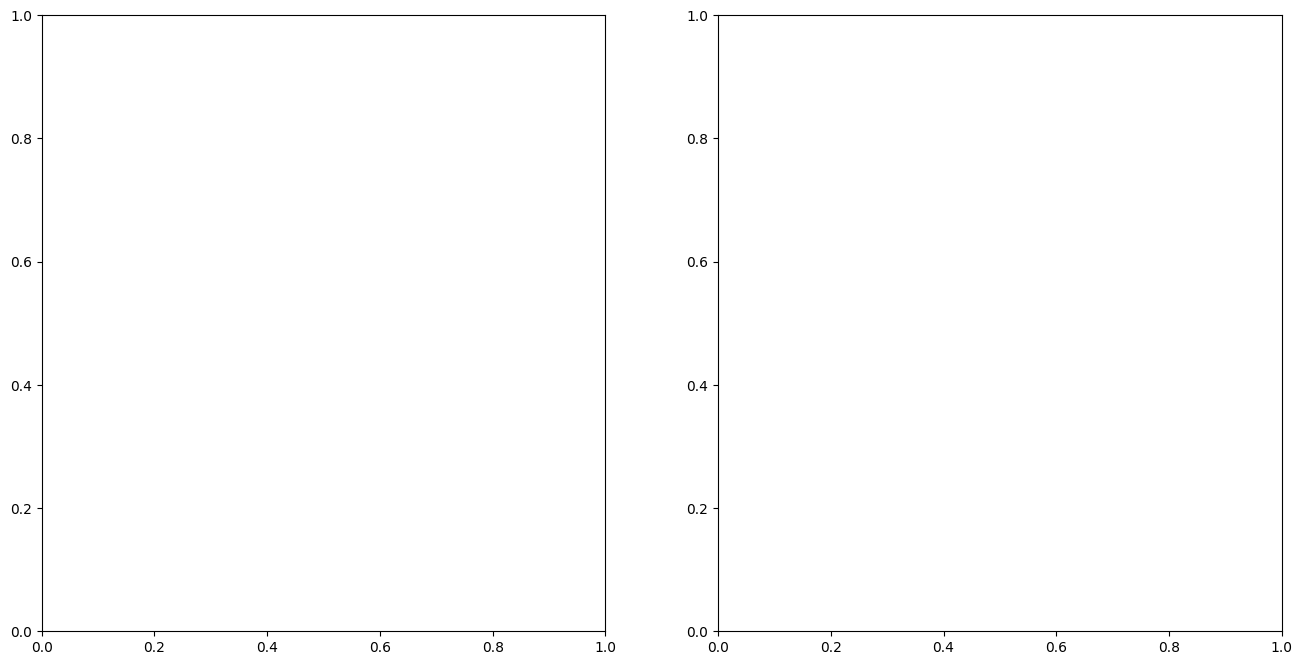

In [8]:
# Generate final high-quality samples
print("=== Final DCGAN Model Evaluation ===")

netG.eval()
netD.eval()

with torch.no_grad():
    # Test discriminator performance
    real_batch = next(iter(dataloader))[0][:32].to(device)
    noise_batch = torch.randn(32, NZ, 1, 1, device=device)
    fake_batch = netG(noise_batch)

    real_scores = netD(real_batch).view(-1)
    fake_scores = netD(fake_batch).view(-1)

    print(f"Discriminator Performance:")
    print(f"  Real images score: {real_scores.mean().item():.3f} ± {real_scores.std().item():.3f}")
    print(f"  Fake images score: {fake_scores.mean().item():.3f} ± {fake_scores.std().item():.3f}")
    print(f"  Separation: {(real_scores.mean() - fake_scores.mean()).item():.3f}")

    # Generate diverse samples for quality assessment
    large_noise = torch.randn(100, NZ, 1, 1, device=device)
    large_samples = netG(large_noise)

    # Analyze sample diversity
    sample_std = large_samples.std().item()
    sample_mean = large_samples.mean().item()

    print(f"\nSample Quality Metrics:")
    print(f"  Sample diversity (std): {sample_std:.4f}")
    print(f"  Sample mean: {sample_mean:.4f}")
    print(f"  Sample range: [{large_samples.min().item():.3f}, {large_samples.max().item():.3f}]")

    if sample_std > 0.3:
        print("  ✓ Good sample diversity")
    else:
        print("  ⚠️ Limited sample diversity (possible mode collapse)")

# Create final showcase
print("\nGenerating final showcase...")
showcase_noise = torch.randn(64, NZ, 1, 1, device=device)
generate_and_save_images(netG, "Final", showcase_noise, device)

# Compare with real images
real_showcase = next(iter(dataloader))[0][:64]
real_showcase = (real_showcase + 1) / 2.0  # Denormalize

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Real images
real_grid = real_showcase[:16]
for i in range(4):
    for j in range(4):
        idx = i * 4 + j
        ax1.add_subplot(4, 4, idx + 1)
        plt.imshow(real_grid[idx].squeeze(), cmap='gray')
        plt.axis('off')
ax1.set_title('Real MNIST Images', fontsize=16)

# Generated images
with torch.no_grad():
    fake_showcase = netG(showcase_noise[:16]).cpu()
    fake_showcase = (fake_showcase + 1) / 2.0

for i in range(4):
    for j in range(4):
        idx = i * 4 + j
        ax2.add_subplot(4, 4, idx + 1)
        plt.imshow(fake_showcase[idx].squeeze(), cmap='gray')
        plt.axis('off')
ax2.set_title('DCGAN Generated Images', fontsize=16)

plt.tight_layout()
plt.show()

print("\n✓ DCGAN training and evaluation completed!")
print("✓ DCGAN demonstrates much more stable training than vanilla GAN")
print("✓ Convolutional architecture produces high-quality, diverse samples")

## Common DCGAN Training Issues and Solutions

Even though DCGAN is more stable than vanilla GAN, issues can still occur. Here's how to diagnose and fix them:

### 1. Mode Collapse in DCGAN 🚨

**Symptoms:**
- Generated images look very similar
- Low sample diversity (std < 0.2)
- Generator loss decreases but variety disappears

**DCGAN-Specific Solutions:**
```python
# Reduce discriminator learning rate
optimizerD = optim.Adam(netD.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Add noise to discriminator inputs
noise_factor = 0.1
real_noisy = real_batch + noise_factor * torch.randn_like(real_batch)
```

### 2. Discriminator Domination 🔥

**Symptoms:**
```
D(x): 0.95+, D(G(z)): 0.05-, D_loss: ~0.1, G_loss: 5.0+
```

**Solutions:**
- **Slower discriminator learning**: Reduce D learning rate to 0.0001
- **Label smoothing**: Use 0.9 for real, 0.1 for fake labels
- **Train G more frequently**: 2-3 G updates per D update

### 3. Training Instability

**Symptoms:**
- Oscillating losses without convergence
- Generated image quality fluctuates dramatically
- Very high loss variance

**DCGAN Solutions:**
- **Verify weight initialization**: Ensure Normal(0, 0.02) is applied
- **Check batch normalization**: Must be applied correctly
- **Confirm architecture**: Follow DCGAN guidelines exactly

### 4. Poor Image Quality

**Common Issues:**
- Blurry or noisy images
- Checkerboard artifacts
- Color bleeding (if using color images)

**Solutions:**
```python
# Ensure proper normalization
transform = transforms.Compose([
    transforms.Resize(64),  # Power of 2 size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [-1, 1] for tanh
])

# Use transposed convolutions carefully
nn.ConvTranspose2d(in_ch, out_ch, 4, 2, 1, bias=False)  # Standard DCGAN
```

### 5. DCGAN-Specific Best Practices

**Architecture Requirements:**
- **Image size**: Use powers of 2 (32, 64, 128, 256)
- **No fully connected layers** except for reshaping
- **Batch normalization** everywhere except G output and D input
- **Specific activations**: ReLU (G), LeakyReLU (D), Tanh (G output), Sigmoid (D output)

**Training Requirements:**
- **Weight initialization**: Normal(0, 0.02) is critical
- **Adam beta1**: Must be 0.5 (not default 0.9)
- **Learning rate**: 0.0002 works best
- **Batch size**: 128 is standard

### 6. Monitoring DCGAN Health

**Healthy DCGAN Training:**
```
D(x): 0.6-0.8, D(G(z)): 0.3-0.5
D_loss: 0.5-1.5, G_loss: 0.5-2.0
Sample diversity: std > 0.3
```

**Red Flags:**
- D(x) > 0.9 and D(G(z)) < 0.1 (discriminator domination)
- Both losses oscillating wildly (instability)
- Generated images look identical (mode collapse)
- Checkerboard patterns (architecture issue)

### 7. Advanced DCGAN Improvements

**For Even Better Stability:**
- **Spectral Normalization**: Stabilizes discriminator
- **Progressive Growing**: Start small, grow image size
- **Self-Attention**: Improves long-range dependencies
- **Hinge Loss**: Alternative to BCE loss

**Modern Variants:**
- **WGAN-GP**: Wasserstein loss with gradient penalty
- **StyleGAN**: Style-based generation
- **BigGAN**: Large-scale high-quality generation

## Key Takeaways: DCGAN vs Other Generative Models

### Advantages of DCGAN
1. **Stable Training**: Much more stable than vanilla GAN
2. **High-Quality Images**: Sharp, realistic samples
3. **Proven Architecture**: Well-established design principles
4. **Research Foundation**: Extensive literature and improvements
5. **Scalable**: Works well from 32×32 to 1024×1024 images

### Limitations of DCGAN
1. **Architecture Constraints**: Must follow specific design rules
2. **Still Adversarial**: Inherits some GAN training challenges
3. **No Likelihood**: Cannot evaluate probability of data
4. **Mode Collapse**: Still possible, though less frequent
5. **Hyperparameter Sensitivity**: Requires specific settings

### DCGAN vs Other Models Comparison

| Aspect | DCGAN | Vanilla GAN | VAE | Real NVP |
|--------|-------|-------------|-----|----------|
| **Training Stability** | Good | Poor | Excellent | Excellent |
| **Sample Quality** | Excellent | Poor | Blurry | Good |
| **Architecture** | Convolutional | FC layers | Encoder-Decoder | Coupling layers |
| **Likelihood** | None | None | Lower bound | Exact |
| **Mode Coverage** | Good | Poor | Excellent | Excellent |
| **Training Speed** | Moderate | Fast | Fast | Slow |
| **Hyperparameter** | Moderate | Extreme | Low | Low |
| **Scalability** | Excellent | Poor | Good | Moderate |

### When to Use DCGAN

**DCGAN is ideal for:**
- **Image generation tasks** (natural images, faces, digits)
- **High-quality sample generation** when likelihood isn't needed
- **Research baseline** for GAN studies
- **Learning GAN concepts** with stable training

**Consider alternatives when:**
- Need **exact likelihood** (use Real NVP/flows)
- Need **stable training guarantees** (use VAE)
- Working with **very high resolution** (use StyleGAN/BigGAN)
- Need **controllable generation** (use conditional models)

### Evolution Beyond DCGAN

**Progressive Improvements:**
1. **WGAN/WGAN-GP** (2017): Better loss function, more stable
2. **Progressive GAN** (2018): High-resolution generation
3. **StyleGAN** (2019): Style-based generation, unprecedented quality
4. **BigGAN** (2019): Large-scale, class-conditional generation
5. **StyleGAN2** (2020): Improved StyleGAN with better quality

**Modern State-of-the-Art:**
- **Diffusion Models** (DDPM, DALL-E 2): Currently best quality
- **VQ-VAE/VQ-GAN**: Discrete representation learning
- **Transformer-based**: GPT-style autoregressive generation

### Best Practices Summary

**For Successful DCGAN Training:**
1. **Follow architecture guidelines exactly**
2. **Use proven hyperparameters** (lr=0.0002, beta1=0.5)
3. **Initialize weights properly** (Normal(0, 0.02))
4. **Monitor training carefully** (losses, sample quality, diversity)
5. **Save checkpoints frequently** (training can suddenly fail)
6. **Be patient** (good results often take 25+ epochs)

**Research Impact:**
DCGAN established the foundation for modern GAN research, proving that adversarial training could work reliably with proper architecture design. Its principles continue to influence state-of-the-art generative models today.

---

**References:**
- Radford, A., Metz, L., & Chintala, S. (2015). Unsupervised representation learning with deep convolutional generative adversarial networks. arXiv preprint arXiv:1511.06434.
- Goodfellow, I., et al. (2014). Generative adversarial nets. NIPS.
- PyTorch DCGAN Tutorial. https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html